# The Blocker Fraud Company

### Authour: João Brum

Blocker Fraude Company is a company specialized in the detection of fraud in financial transactions made through mobile devices. The company has a service called “Blocker Fraud” which guarantees the blocking of fraudulent transactions.

And the company's business model is of the Service type, with monetization made by the performance of the service provided, that is, the user pays a fixed fee on the success in detecting fraud in the client's transactions.

However, Blocker Fraud Company is expanding in Brazil and in order to acquire customers more quickly, it has adopted a very aggressive strategy. The strategy works as follows: 

- The company will receive 25% of the value of each transaction that is truly detected as fraud.
- The company will receive 5% of the value of each transaction detected as fraud, however the transaction is truly legitimate.
- The company will return 100% of the value to the customer for each transaction detected as legitimate, however the transaction is truly a fraud.

With this aggressive strategy, the company assumes the risks of failing to detect fraud and is compensated for assertively detecting fraud.

For the client, it is an excellent deal to hire Blocker Fraud Company. Although the fee charged is very high on success, 25%, the company reduces its costs with correctly detected fraudulent transactions and even the damage caused by an error in the anti-fraud service will be covered by the Blocker Fraud Company itself.

For the company, in addition to getting many customers with this risky strategy of guaranteeing reimbursement in the event of a failure to detect customer fraud, it only depends on the precision and accuracy of the models built by its Data Scientists, that is, how much the more accurate the “Blocker Fraud” model, the higher the company's revenue. However, if the model has low precision, the company could have a huge loss. 

### The Challenge

You have been hired as a Data Science Consultant to create a highly accurate and highly accurate model for detecting fraud in transactions made through mobile devices.

At the end of your consultancy, you need to provide the CEO of Blocker Fraud Company with a model in production that will be accessed via API, meaning clients will send their transactions via API for your model to classify them as fraudulent or legitimate.

In addition, you will need to submit a report reporting your model's performance and results in relation to the profit and loss the company will make using the model you produced. Your report should contain the answers to the following questions:

1. What is the Precision and Accuracy of the model?
2. How Reliable is the model in classifying transactions as legitimate or fraudulent?
3. What is the Company's Expected Revenue if we classify 100% of transactions with the model?
4. What is the expected loss by the company in case of model failure?
5. What is the expected profit for the client and for the Blocker Fraud Company when using the model? 

### Data Source

https://www.kaggle.com/ntnu-testimon/paysim1

https://sejaumdatascientist.com/crie-uma-solucao-para-fraudes-em-transacoes-financeiras-usando-machine-learning/

### Data Dictionary

- step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

- amount - amount of the transaction in local currency.

- nameOrig - customer who started the transaction

- oldbalanceOrg - initial balance before the transaction

- newbalanceOrig - new balance after the transaction

- nameDest - customer who is the recipient of the transaction

- oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

- newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

- isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

- isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

## 0.0 Imports 

In [25]:
!pip install catboost

  Using cached plotly-5.3.1-py2.py3-none-any.whl (23.9 MB)
  Using cached tenacity-8.0.1-py3-none-any.whl (24 kB)


In [26]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from datetime import datetime, timedelta
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from imblearn import combine as c

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
#from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix


from IPython.display import Image

In [27]:
# Set the style
sns.set_style('darkgrid')

# Set to display an unlimited number of columns and rows
pd.options.display.max_columns = None
pd.options.display.max_rows = None


### 0.1 Helper Functions

In [28]:

def camel_to_snake(s):
    # Function that converts camel style to snake style
    return ''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_')

In [29]:
def descriptive_analysis(numerical_df):
    # Function that calculate all the statistics measures for the dataset
    # Central tendency - Mean, median
    ct1 = pd.DataFrame(numerical_df.apply(np.mean)).T
    ct2 = pd.DataFrame(numerical_df.apply(np.median)).T

    # Dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(numerical_df.apply(np.std)).T
    d2 = pd.DataFrame(numerical_df.apply(min)).T
    d3 = pd.DataFrame(numerical_df.apply(max)).T
    d4 = pd.DataFrame(numerical_df.apply(lambda x: x.max() - x.min())).T
    d5 = pd.DataFrame(numerical_df.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(numerical_df.apply(lambda x: x.kurtosis())).T

    # Concatenate
    m = pd.concat([ct1, ct2, d1,d2,d3,d4,d5,d6]).T.reset_index()
    m.columns = ["Attributes", "Mean", "Median", "Std", "Min", "Max", "Range", "Skew", "Kurtosis"]

    return m

In [30]:
# Function that put the information of values inside the graphic
def label_graph(ax, fmt):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), fmt), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

In [31]:
# Function that customize the plot
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)

In [32]:
 def find_outliers(df, col_name):
    # Calculates Q1, Q3 and IQR
    Q1 = np.quantile(df[col_name], 0.25)
    Q3 = np.quantile(df[col_name], 0.75)
    IQR = Q3 - Q1

    # Calculates the outliers boundaries through statistical relationship
    low_outliers = Q1 - 1.5 * IQR
    high_outliers = Q3 + 1.5 * IQR

    print('Outliers limit for {}:'.format(col_name))
    print(f"Q1 = {Q1}\nQ3 = {Q3}\nIQR = {IQR}\nlow_outliers = {low_outliers}\nhigh_outliers = {high_outliers}")
    
    return low_outliers, high_outliers

In [33]:
# Function that measures the association between two categorical variables
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))

    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

In [34]:
# Function to calculate the metrics and display as dataframe
def get_metrics(model_name, y_true, y_hat):
  # Calculate the metrics
  acc = accuracy_score(y_true, y_hat)

  prec = precision_score(y_true, y_hat)

  rec = recall_score(y_true, y_hat)

  f1 = f1_score(y_true, y_hat)


  return pd.DataFrame([[model_name, acc, prec, rec, f1]], columns = ['Model Name', 'Accuracy', 'Precision', 'Recall', 'F1-Score'], index = [0])


In [35]:
# Function to use cross-validation over the stratified K-fold
def cross_validation(model_name, model, X, y, cv):
  acc_list = []
  rec_list = []
  prec_list = []
  f1_list = []

  X = X.reset_index(drop = True)
  y = y.reset_index(drop = True)
  

  # Using Stratified K Fold allows to split the classes with same proportion as X dataset
  fold = StratifiedKFold(n_splits=cv, random_state=42, shuffle=True)

  # Loop for each fold
  for train_index, test_index in fold.split(X, y):

    # Split in train and test
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]

    X_test = X.loc[test_index]
    y_test = y.loc[test_index]

    # Fit the model
    model = model.fit(X_train, y_train)

    # Generate the predictions
    preds = model.predict(X_test)

    # Metrics
    acc = accuracy_score(y_test, preds)
    rec = recall_score(y_test, preds)
    prec = precision_score(y_test, preds)
    f1_sc = f1_score(y_test, preds)

    # Append the metrics
    acc_list.append(acc)
    rec_list.append(rec)
    prec_list.append(prec)
    f1_list.append(f1_sc)

    

  # Return the dataframe with the metrics after cross-validation
  return pd.DataFrame( { 'Model': [model_name],
                        'Accuracy CV': np.round(np.mean(acc_list), 3).astype(str) + ' +/- ' + np.round(np.std(acc_list), 5).astype(str),
                        'Precision CV': np.round(np.mean(prec_list), 3).astype(str) + ' +/- ' + np.round(np.std(prec_list), 5).astype(str),
                        'Recall CV': np.round(np.mean(rec_list), 3).astype(str) + ' +/- ' + np.round(np.std(rec_list), 5).astype(str),
                        'F1-Score CV': np.round(np.mean(f1_list), 3).astype(str) + ' +/- ' + np.round(np.std(f1_list), 5).astype(str)},index = [0])



### 0.2 Loading Data

In [36]:
# Read CSV
df0 = pd.read_csv('../data/historical_data.csv',low_memory=True)

In [37]:
# Display the first 5 rows
df0.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### 0.3 Resample dataset

Due to computational resources, I had to resample the majority class, in order to reduce the dataset size without harming the balance of the target classes. I'm using 30% of the majority class and 70% of minority class.

In [38]:
df_majority = df0[df0['isFraud']==0]
df_minority = df0[df0['isFraud']==1]


majority_size = len(df_majority)
minority_size = len(df_minority)


# Combine majority class with upsampled minority class
df_sampled = pd.concat([df_majority.sample(int(majority_size * 0.3)), df_minority.sample(int(minority_size * 0.7))])

# Display new class counts

print('Before resample:', df0.shape)
print('After resample:', df_sampled.shape)

Before resample: (6362620, 11)
After resample: (1912071, 11)


In [39]:
df_sampled = df_sampled.sort_index().reset_index(drop = True)

In [40]:
df_sampled.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.00,0,0
1,1,DEBIT,5337.77,C712410124,41720.0,36382.23,C195600860,41898.0,40348.79,0,0
2,1,DEBIT,9644.94,C1900366749,4465.0,0.00,C997608398,10845.0,157982.12,0,0
3,1,PAYMENT,3099.97,C249177573,20771.0,17671.03,M2096539129,0.0,0.00,0,0
4,1,PAYMENT,11633.76,C1716932897,10127.0,0.00,M801569151,0.0,0.00,0,0


## 1.0 Data Description

This section give to you the understanding of the dataset, through the features it has.

In [41]:
df1 = df0.copy()

In [42]:
df1.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

### 1.1 Rename Columns

In [43]:
cols_old = ['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
           'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
           'isFlaggedFraud']

snake_case = lambda x: camel_to_snake(x)

cols_new = list(map(snake_case, cols_old))

df1.columns = cols_new

In [44]:
df1.rename(columns = {'oldbalance_org' : 'oldbalance_orig'}, inplace = True)

### 1.2 Data Dimensions

In [45]:
print("Number of examples:", df1.shape[0])
print("Number of features:", df1.shape[1])

Number of examples: 6362620
Number of features: 11


### 1.3 Data Type

In [46]:
df1.dtypes

step                  int64
type                 object
amount              float64
name_orig            object
oldbalance_orig     float64
newbalance_orig     float64
name_dest            object
oldbalance_dest     float64
newbalance_dest     float64
is_fraud              int64
is_flagged_fraud      int64
dtype: object

### 1.4 Checking Missing Values

In [47]:
df1.isna().sum()

step                0
type                0
amount              0
name_orig           0
oldbalance_orig     0
newbalance_orig     0
name_dest           0
oldbalance_dest     0
newbalance_dest     0
is_fraud            0
is_flagged_fraud    0
dtype: int64

The dataset does not have missing values.

### 1.5 Descriptive Statistics

#### 1.5.1 Numerical Attributes

In [48]:
num_attributes = df1.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [49]:
desc_analysis = descriptive_analysis(num_attributes)
desc_analysis

,Attributes,Mean,Median,Std,Min,Max,Range,Skew,Kurtosis
0,step,2.433972e+02,239.000,1.423320e+02,1.0,7.430000e+02,7.420000e+02,0.375177,0.329071
1,amount,1.798619e+05,74871.940,6.038582e+05,0.0,9.244552e+07,9.244552e+07,30.993949,1797.956705
2,oldbalance_orig,8.338831e+05,14208.000,2.888242e+06,0.0,5.958504e+07,5.958504e+07,5.249136,32.964879
3,newbalance_orig,8.551137e+05,0.000,2.924048e+06,0.0,4.958504e+07,4.958504e+07,5.176884,32.066985
4,oldbalance_dest,1.100702e+06,132705.665,3.399180e+06,0.0,3.560159e+08,3.560159e+08,19.921758,948.674125
5,newbalance_dest,1.224996e+06,214661.440,3.674129e+06,0.0,3.561793e+08,3.561793e+08,19.352302,862.156508
6,is_fraud,1.290820e-03,0.000,3.590479e-02,0.0,1.000000e+00,1.000000e+00,27.779538,769.702982
7,is_flagged_fraud,2.514687e-06,0.000,1.585775e-03,0.0,1.000000e+00,1.000000e+00,630.603629,397659.062500


- **step** has 743 hours of simulation;
- The variable **amount, oldbalance_orig, new_balance_orig, oldbalance_dest, new_balance_dest** are very skewd and have a lot of kurtosis, it indicates that does not follow a normal distribution;
- Median of the variables mentioned above can represent better the central tendency;
- **is_fraud** and **is_flagged_fraud** are binary variables;

#### 1.5.2 Categorical Attributes

In [50]:
cat_attributes.nunique()

type               5
name_orig    6353307
name_dest    2722362
dtype: int64

- 6.35kk of unique people started a transaction and 2.72kk of unique people received a transaction.

<AxesSubplot:xlabel='type', ylabel='count'>

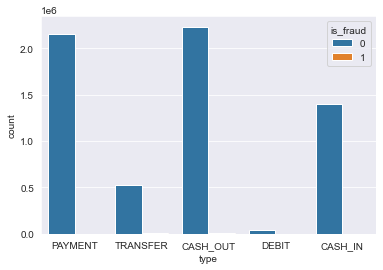

In [51]:
sns.countplot(x = 'type', hue = 'is_fraud', data = df1)

- It is impossible to analyze NOW the impact of **is_fraud** in variable **type** due to dataset imbalance;
- The most common form of transaction is **cash_out**, followed by **payment** and **cash_in**. 

## 2.0 Feature Engineering

The section of Feature Engineering involves leveraging data mining techniques to extract features from raw data along with the use of domain knowledge. This may be useful to improve the performance of machine learning algorithms and also to get experience about the business model in order to generate new insights.

In [52]:
df2 = df1.copy()

### 2.1 Hypothesis Mind Map

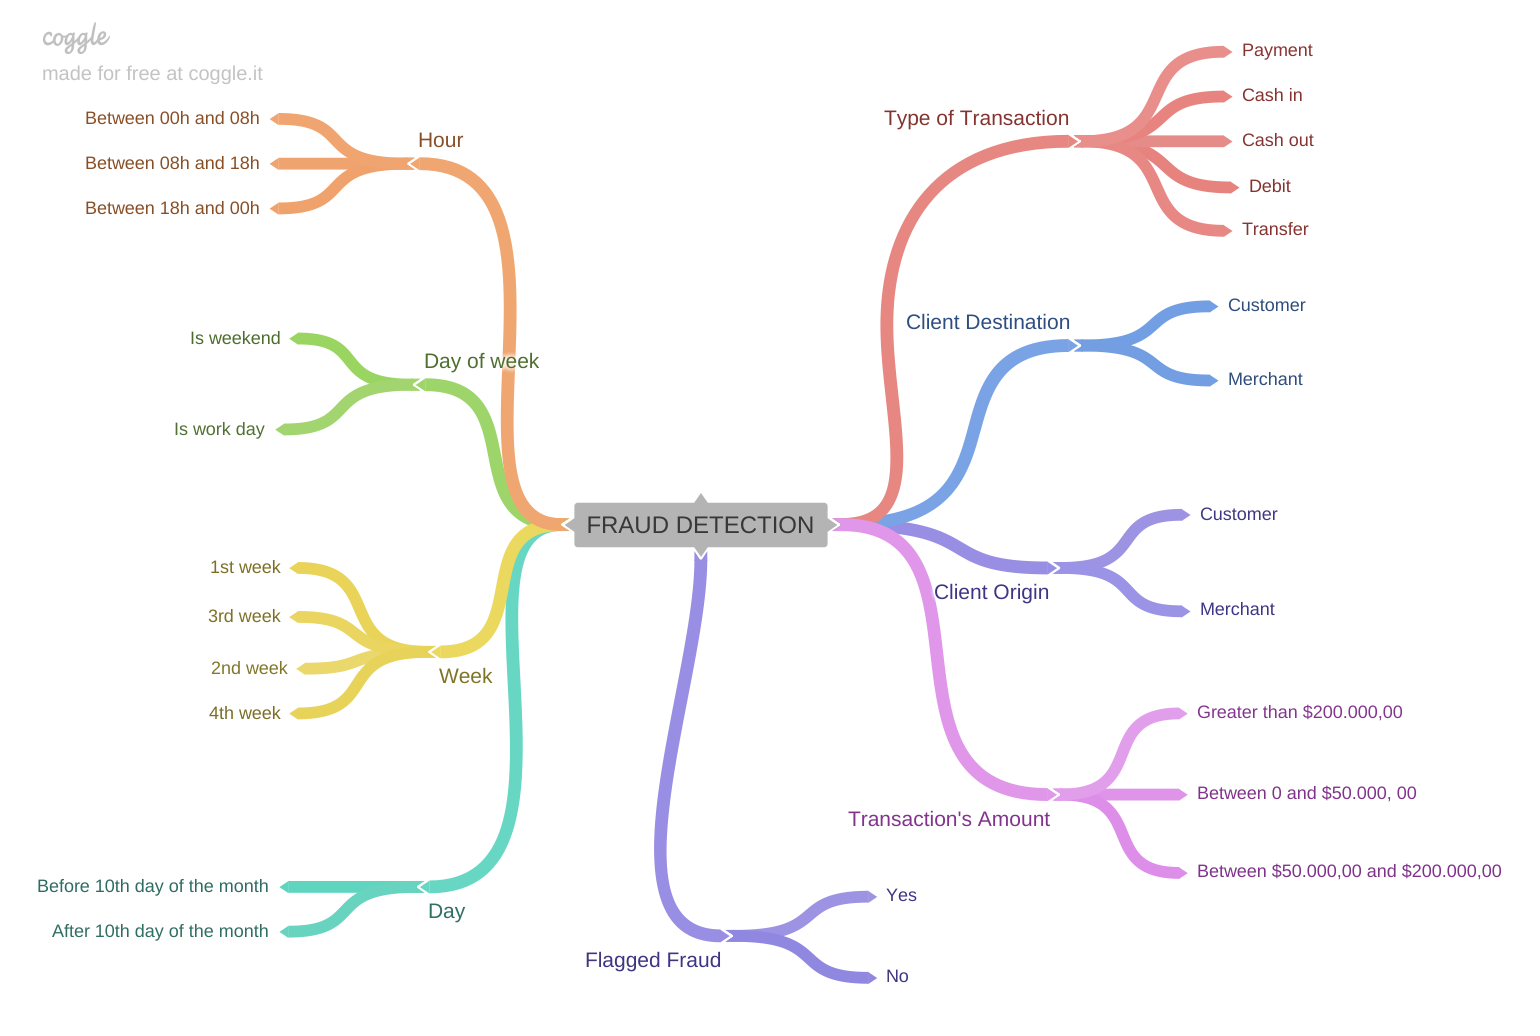

In [53]:
Image('../images/mind_map_fraud.png')

### 2.2 Hypothesis List

**H1** - Transactions classified as transfer is more likely to be fraud;

**H2** - The average amount of money of fraudulent transactions classified as transfer is the highest value.

**H3** - Customer-customer transactions tend to be more fraudulent than Customer-Merchant.

**H4** - Transactions over \\$200.000,00 are always fraudulent.

**H5** - Transactions between 0 and \\$50.000,00 are more likely to be fraud than those between \\$50.000,00 and \\$200.000,00.

**H6** - Transactions before the 10th day of the month are more likely to be fraud.

**H7** - The first week of the month are more likely to be fraud.

**H8** - Transactions during the work day are more likely to be fraud.

**H9** - Transactions after 18h are more likely to be fraud.

**H10** - When the transaction reach oldbalance_old equal zero, it is more likely to be fraud;

**H11** - When the transaction has an amount greater than oldbalance_old, it is more likely to be fraud;

Since it is a simulation of 30 days, I am going to consider it from a specific time in the beginning of the month. 

In [54]:
# Function that calculates the error after a transaction in the origin side
def error_after_transaction_orig(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old + amount - new
    elif transaction_type == 'CASH_OUT':
        return old - amount - new
    elif transaction_type == 'DEBIT':
        return old - amount - new
    elif transaction_type == 'PAYMENT':
        return old - amount - new
        
    else:
        return old - amount - new

In [55]:
# Function that calculates the error after a transaction in the destination side
# NEW and OLD balance for Merchants are always 0
def error_after_transaction_dest(transaction_type, old, new, amount):
    if transaction_type == 'CASH_IN':
        return old - amount - new
    elif transaction_type == 'CASH_OUT':
        return old + amount - new
    elif transaction_type == 'DEBIT':
        return old + amount - new
    elif transaction_type == 'PAYMENT':
        return 0 
        
    else:
        return old + amount - new

In [56]:
#  Stratifying the transaction's amount 
df2['amount_group'] = df2['amount'].apply(lambda x: 0 if x < 50000 else 1 if (x >=50000) & (x < 200000) else 2)

# Since it is a simulation, I'm going to consider it started in 01/09/2015 00:00:00 and each step is one hour
df2['date'] = df2['step'].apply(lambda x:  datetime(2015, 9, 1, 00, 00, 00) + timedelta(hours=x))

# Extract day
df2['day'] = df2['date'].dt.day

# Extract day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# Extract the week
df2['week'] = df2['day'].apply(lambda x:
                                         1 if 1 <= x <= 7 else
                                         2 if 8 <= x <= 15 else
                                         3 if 16 <= x <= 23 else
                                         4)

# Extract hour
df2['hour'] = df2['date'].dt.hour

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_orig'] = df2.apply(lambda x: error_after_transaction_orig(x['type'], x['oldbalance_orig'], x['newbalance_orig'], x['amount']), axis = 1)

# The error after the transaction is calculated based on type of transaction, this can help the model to find when the money didn't add or subtract from the bank account
df2['error_after_tran_dest'] = df2.apply(lambda x: error_after_transaction_dest(x['type'], x['oldbalance_dest'], x['newbalance_dest'], x['amount']), axis = 1)

# Define if a client of origin is a Customer or a Merchant
df2['client_origin'] = df2['name_orig'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')

# Define if a client of destination is a Customer or a Merchant
df2['client_destination'] = df2['name_dest'].apply(lambda x: 'Customer' if 'C' in x else 'Merchant')


In [57]:
df2.sample()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,amount_group,date,day,day_of_week,week,hour,error_after_tran_orig,error_after_tran_dest,client_origin,client_destination
5420877,378,PAYMENT,1566.54,C2093360414,280561.34,278994.8,M529097254,0.0,0.0,0,0,0,2015-09-16 18:00:00,16,2,3,18,5.820766e-11,0.0,Customer,Merchant


## 3.0 Data Filtering

In [58]:
df3 = df2.copy()

In [59]:
cols_to_drop = ['step', 'name_orig', 'name_dest']
df3 = df3.drop(cols_to_drop, axis = 1)

- I've dropped the **step** column due to creation of a date column;
- I've dropped **name_orig** and **name_dest** because I don't believe there are more informations than Customer and Merchant in this moment.

## 4.0 Exploratory Data Analysis (EDA)

This section is used to understand the business and the dataset. It is the most important part to report some useful insights for the managers. To analyze it, I will consider 3 analysis:

Univariate - The distribution, countplot and boxplot of each variable. It is important to remove outliers further.

Bivariate - All the hypothesis can be answered in this subsection. It can analyze the impact of each feature in the target variable;

Multivariate - Important to remove colinearity.

In [ ]:
df4 = df3.copy()

### 4.1 Univariate Analysis

#### 4.1.1 Target Variable

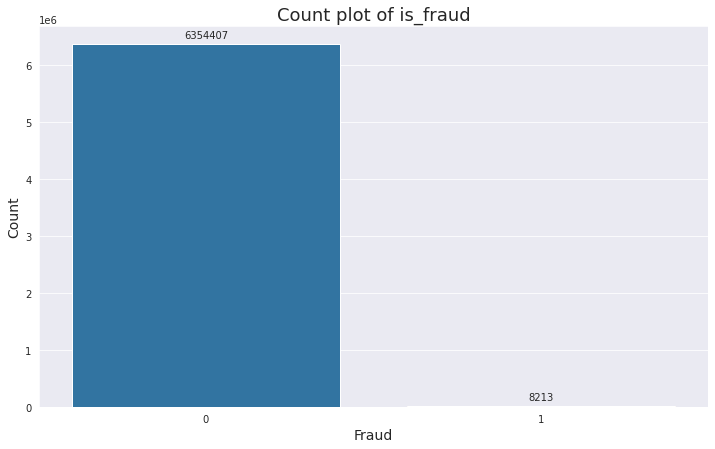

In [ ]:
plt.figure(1, figsize=(12,7))
ax = sns.countplot(x = 'is_fraud', data = df4)

set_plots_features(ax, 'Count plot of is_fraud', 'Fraud', 'Count')
label_graph(ax, 'd')

It is not possible to visualize the graphic well due to the imbalance on the dataset. This problem need to be fixed in the following sections.

#### 4.1.2 Numerical Attributes

In [ ]:
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])

In [ ]:
num_attributes.shape

(6362620, 14)

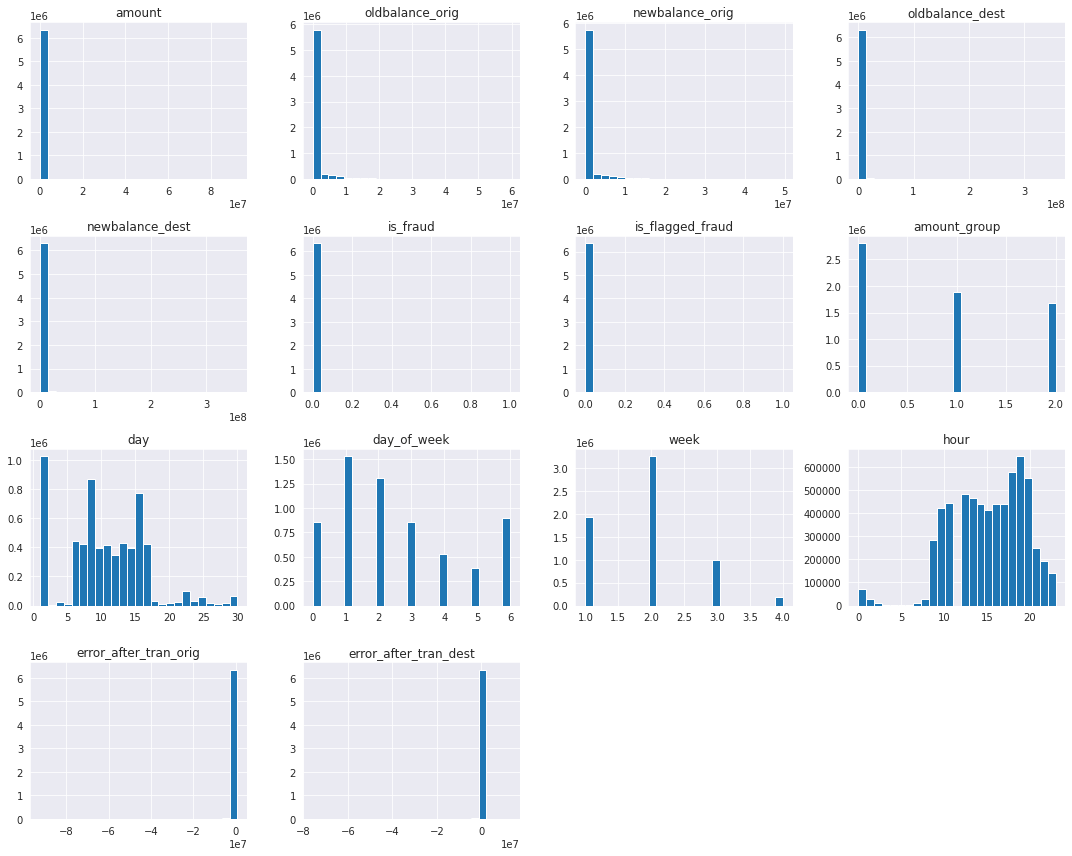

In [ ]:
num_attributes.hist(bins=25, figsize=(15,12))
plt.tight_layout()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn

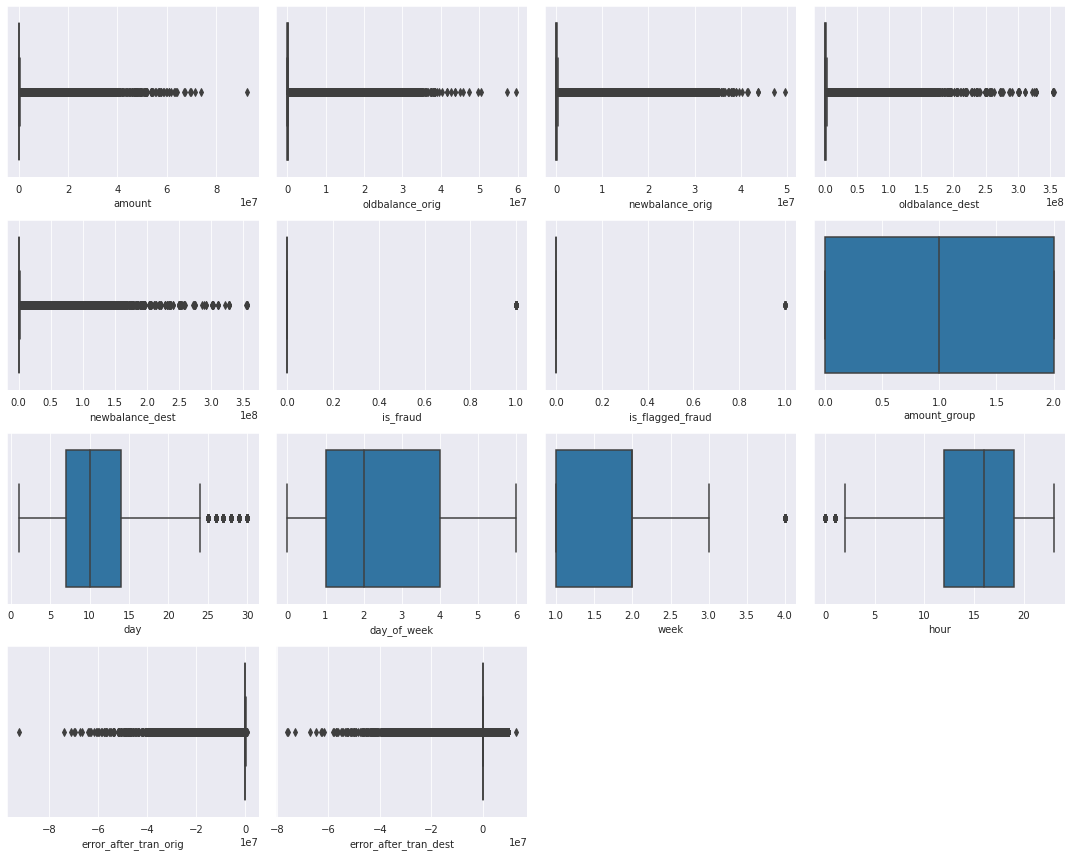

In [ ]:
plt.figure(1, figsize = (15,12))
for i, col in enumerate(num_attributes.columns):
    plt.subplot(4, 4, i+1)
    sns.boxplot(num_attributes[col])
    plt.xlabel(col)
    
plt.tight_layout()

- By using  histogram and boxplot, it is possible to check that the dataset contains a lot of outliers with exception of time feature. Then, I will analyze it filtering the outliers with IQR method.

Outliers limit for amount:
Q1 = 13389.57
Q3 = 208721.47750000004
IQR = 195331.90750000003
low_outliers = -279608.29125000007
high_outliers = 501719.3387500001


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f3f66550>]],
      dtype=object)

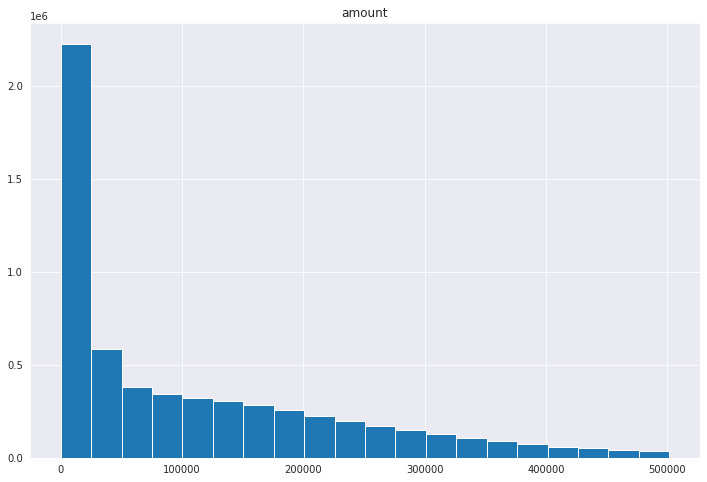

In [ ]:
# Amount
low, high = find_outliers(num_attributes,  'amount')    
num_attributes[(num_attributes['amount'] > low) & (num_attributes['amount'] < high)].hist(column = 'amount', bins = 20, figsize = (12,8))

Outliers limit for oldbalance_orig:
Q1 = 0.0
Q3 = 107315.175
IQR = 107315.175
low_outliers = -160972.7625
high_outliers = 268287.9375


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f367e7d0>]],
      dtype=object)

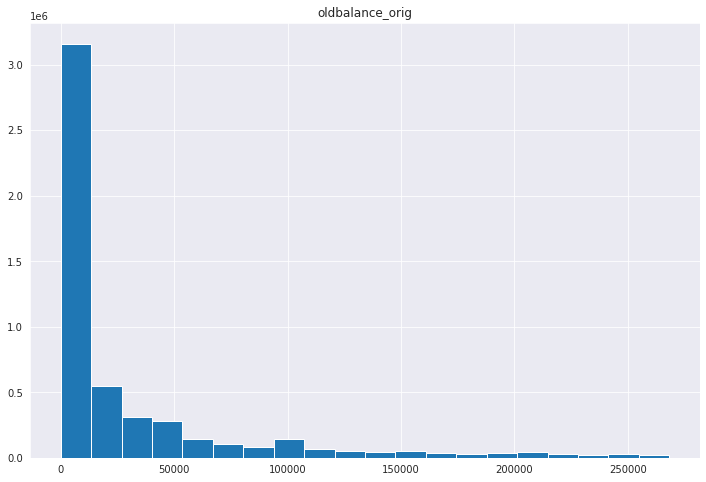

In [ ]:
# Amount
low, high = find_outliers(num_attributes,  'oldbalance_orig')    
num_attributes[(num_attributes['oldbalance_orig'] > low) & (num_attributes['oldbalance_orig'] < high)].hist(column = 'oldbalance_orig', bins = 20, figsize = (12,8))

Outliers limit for newbalance_orig:
Q1 = 0.0
Q3 = 144258.41
IQR = 144258.41
low_outliers = -216387.615
high_outliers = 360646.025


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f21e4d50>]],
      dtype=object)

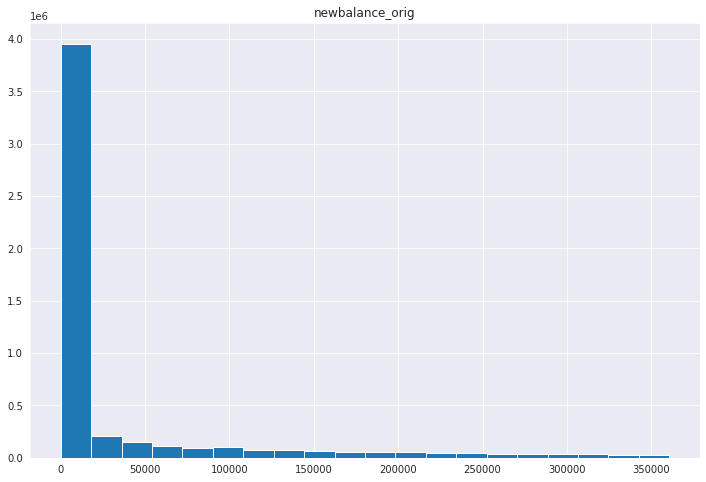

In [ ]:
# Newbalance_orig
low, high = find_outliers(num_attributes,  'newbalance_orig')    
num_attributes[(num_attributes['newbalance_orig'] > low) & (num_attributes['newbalance_orig'] < high)].hist(column = 'newbalance_orig', bins = 20, figsize = (12,8))

Outliers limit for oldbalance_dest:
Q1 = 0.0
Q3 = 943036.7075
IQR = 943036.7075
low_outliers = -1414555.06125
high_outliers = 2357591.76875


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f15ca210>]],
      dtype=object)

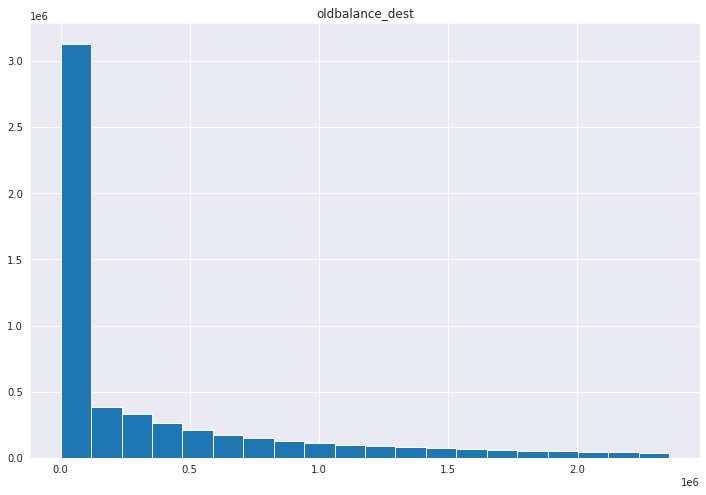

In [ ]:
# Amount
low, high = find_outliers(num_attributes,  'oldbalance_dest')    
num_attributes[(num_attributes['oldbalance_dest'] > low) & (num_attributes['oldbalance_dest'] < high)].hist(column = 'oldbalance_dest', bins = 20, figsize = (12,8))

Outliers limit for newbalance_dest:
Q1 = 0.0
Q3 = 1111909.25
IQR = 1111909.25
low_outliers = -1667863.875
high_outliers = 2779773.125


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0e88eed10>]],
      dtype=object)

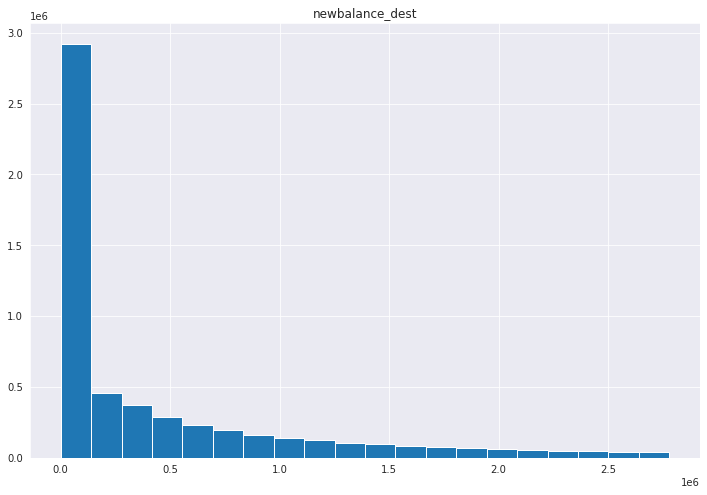

In [ ]:
# Newbalance_dest
low, high = find_outliers(num_attributes,  'newbalance_dest')    
num_attributes[(num_attributes['newbalance_dest'] > low) & (num_attributes['newbalance_dest'] < high)].hist(column = 'newbalance_dest', bins = 20, figsize = (12,8))

Outliers limit for error_after_tran_orig:
Q1 = -114500.0925
Q3 = 0.0
IQR = 114500.0925
low_outliers = -286250.23124999995
high_outliers = 171750.13874999998


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0f15ca750>]],
      dtype=object)

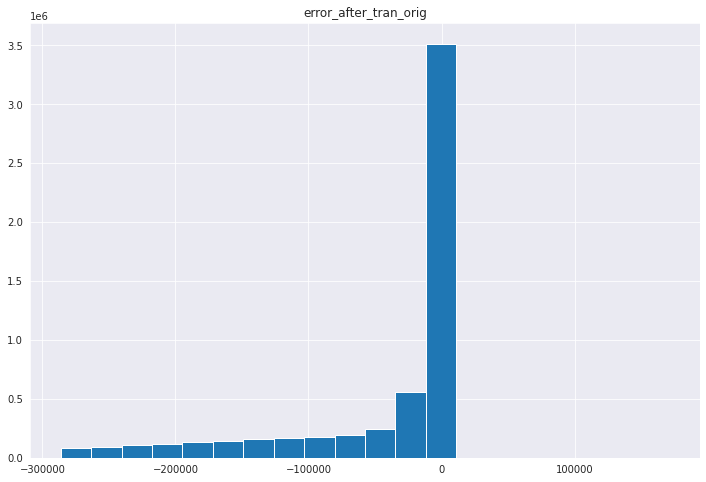

In [ ]:
# Error_after_tran_orig
low, high = find_outliers(num_attributes,  'error_after_tran_orig')    
num_attributes[(num_attributes['error_after_tran_orig'] > low) & (num_attributes['error_after_tran_orig'] < high)].hist(column = 'error_after_tran_orig', bins = 20, figsize = (12,8))

Outliers limit for error_after_tran_dest:
Q1 = 0.0
Q3 = 0.0
IQR = 0.0
low_outliers = 0.0
high_outliers = 0.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fa0e9c579d0>]],
      dtype=object)

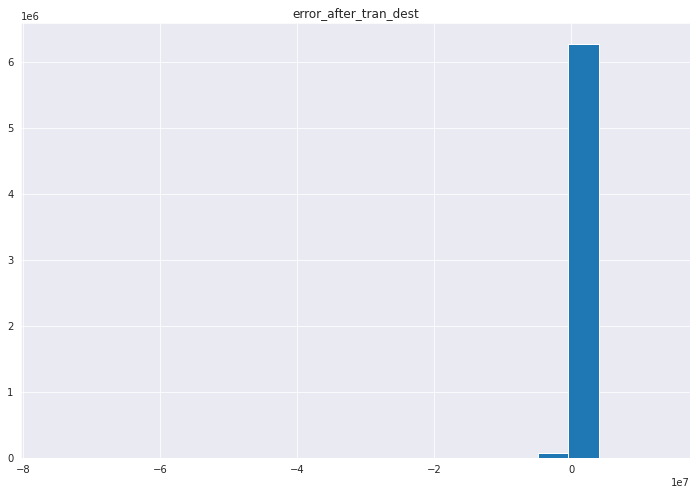

In [ ]:
# Error_after_tran_dest
low, high = find_outliers(num_attributes,  'error_after_tran_dest')    
num_attributes.hist(column = 'error_after_tran_dest', bins = 20, figsize = (12,8))

In [ ]:
df4['error_after_tran_dest'].value_counts(normalize=True).head()*100

 0.00    66.796163
 0.01     2.989743
-0.01     2.988879
 0.01     1.155232
-0.01     1.151695
Name: error_after_tran_dest, dtype: float64

In [ ]:
df4['error_after_tran_orig'].value_counts(normalize=True).head()*100

 0.00    30.532485
-0.01     0.754501
 0.01     0.751844
 0.01     0.732513
-0.01     0.730014
Name: error_after_tran_orig, dtype: float64

**Summary of histogram analysis**:
- Most values are 0;
- Values follows a exponential distribution;
- The error after a transaction in destination smaller than in the origin.

#### 4.1.3 Categorical Attributes

In [ ]:
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

In [ ]:
cat_attributes['type'].value_counts(normalize = True)*100

CASH_OUT    35.166331
PAYMENT     33.814608
CASH_IN     21.992261
TRANSFER     8.375622
DEBIT        0.651178
Name: type, dtype: float64

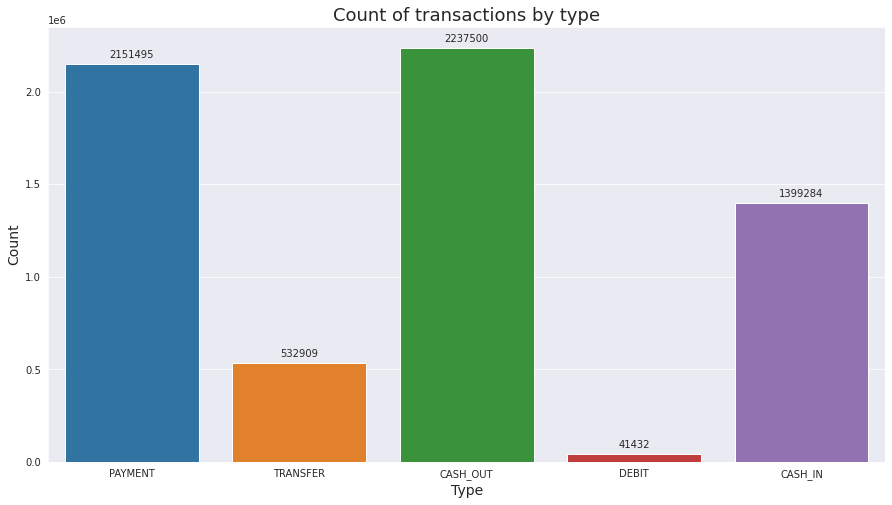

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'type', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by type', 'Type', 'Count')

- The most common types of transactions are CASH-OUT (35%) and PAYMENT (34%);

In [ ]:
cat_attributes['client_origin'].value_counts(normalize = True)*100

Customer    100.0
Name: client_origin, dtype: float64

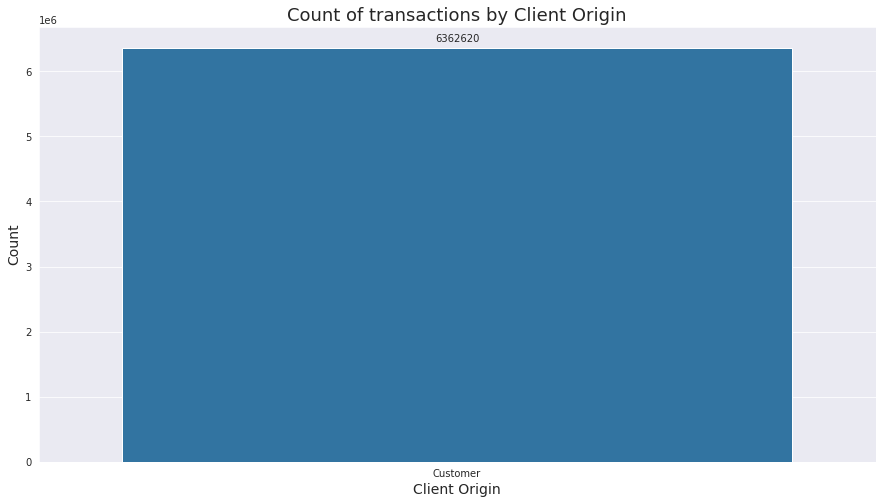

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'client_origin', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by Client Origin', 'Client Origin', 'Count')

- All the transactions from Origin side are done by Customers (100%).

In [ ]:
cat_attributes['client_destination'].value_counts(normalize = True)*100

Customer    66.185392
Merchant    33.814608
Name: client_destination, dtype: float64

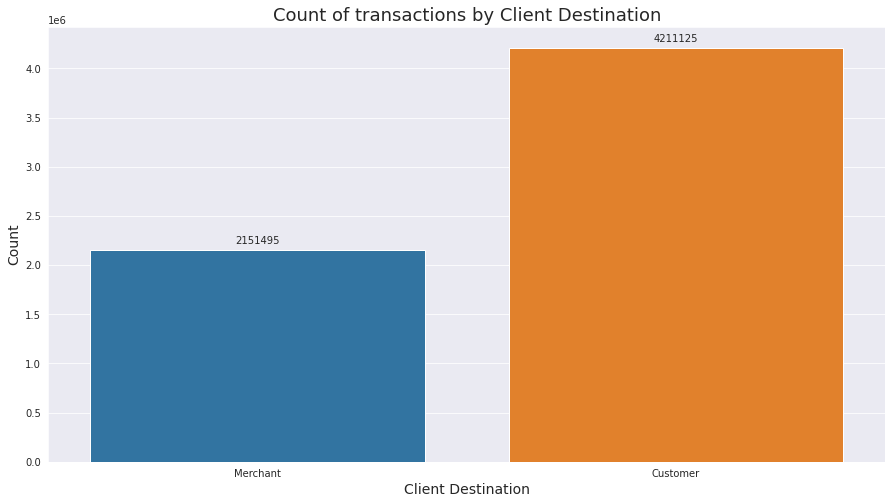

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.countplot(x = 'client_destination', data = cat_attributes)
label_graph(ax, 'd')
set_plots_features(ax, 'Count of transactions by Client Destination', 'Client Destination', 'Count')

- Analyzing  the Destination side, 66% of transactions are done from Customer to Customer and 34% from Customer to Merchant.

### 4.2 Bivariate Analysis

Bivariate Analysis will be used to validate all the hypothesis generated in the hypothesis list.

#### H1- Transactions classified as transfer is more likely to be fraud;
**FALSE**: Cash-Out and Transfer have almost the same number of fraud transactions, then it is not possible to affirm it.
However, when compared with regular transactions, transfer type is significantly greater than the regular ones (49.9% x 8.3%).

In [ ]:
aux1 = df4[['type', 'is_fraud']].groupby('type').sum()
aux1.T

type,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
is_fraud,0,4116,0,0,4097


In [ ]:
type_counts = (df4.groupby(['is_fraud'])['type']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .sort_values('type'))

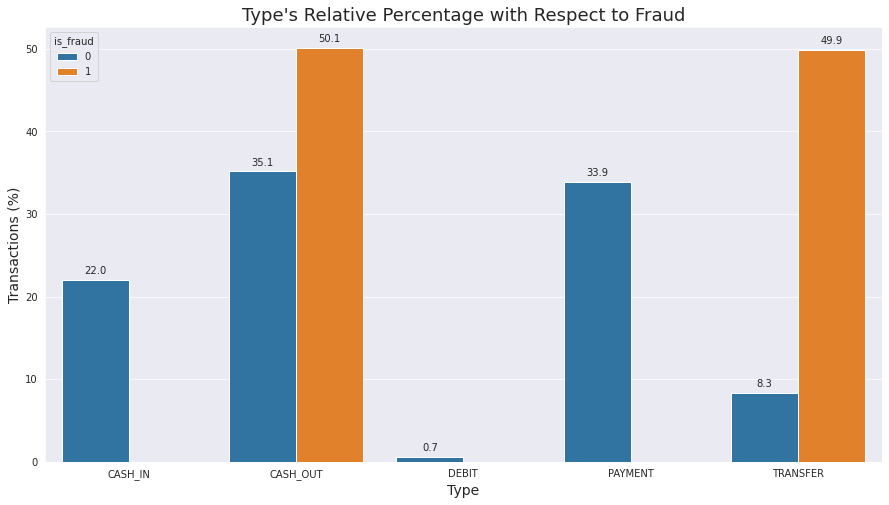

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x="type", y="percentage", hue="is_fraud", data=type_counts)
label_graph(ax, '.1f')
set_plots_features(ax, 'Type\'s Relative Percentage with Respect to Fraud', 'Type', 'Transactions (%)')

- Only Transfer and Cash-Out type transaction occur when a Fraud happen;
- Transfer and Cash-out have almost the same occurences of Fraud;
- When compared to relative percentage related to Fraud, Transfer is significantly greater than the regular transaction. Cash-out transaction is significanly greater too, but less than the the transfer comparison.

#### H2 - The average amount of money of fraudulent transactions classified as transfer is the highest value.
**TRUE**: The average amount of money by transaction is the highest value when a Fraud happen, followed by Cash-out with close values.

In [ ]:
aux = df4.groupby(['is_fraud', 'type'])['amount'].mean().reset_index().sort_values('amount', ascending = False)
aux

,is_fraud,type,amount
6,1,TRANSFER,1.480892e+06
5,1,CASH_OUT,1.455103e+06
4,0,TRANSFER,9.062290e+05
1,0,CASH_OUT,1.739172e+05
0,0,CASH_IN,1.689202e+05
3,0,PAYMENT,1.305760e+04
2,0,DEBIT,5.483665e+03


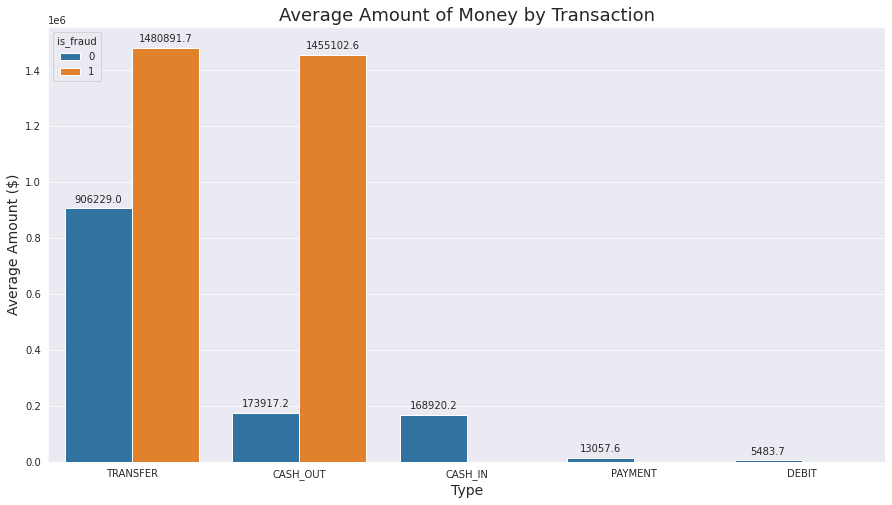

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'type', y = 'amount', hue = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Average Amount of Money by Transaction', 'Type', 'Average Amount ($)')



- The highest average amount of money related to fraud is from a Transfer transaction type;
- The difference of average amount of money is quite discrepant when a fraud occurs.

#### H3 - Customer-customer transactions tend to be more fraudulent than Customer-Merchant.



**TRUE**: There is no transaction Customer-Merchant which is classified as Fraud.

In [ ]:
aux = df4[['client_destination', 'is_fraud']].groupby('client_destination')['is_fraud'].sum().reset_index()
aux

,client_destination,is_fraud
0,Customer,8213
1,Merchant,0


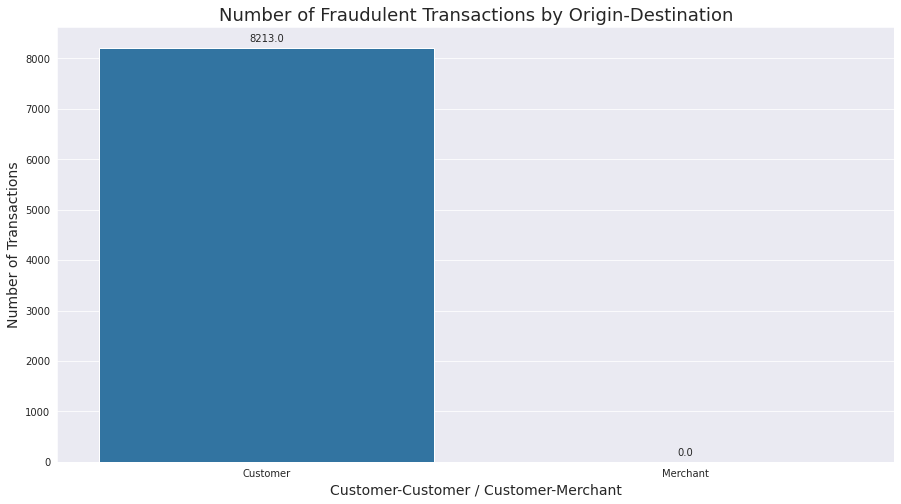

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'client_destination', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Origin-Destination', 'Customer-Customer / Customer-Merchant', 'Number of Transactions')



#### H4 - Transactions over \\$200.000,00 are always fraudulent.



**FALSE**: The number of fraudulent transactions is greater in transactions over $2000.000,00, but is not always.

In [ ]:
aux = df4[['amount_group', 'is_fraud']].groupby('amount_group')['is_fraud'].sum().reset_index()
aux

,amount_group,is_fraud
0,0,1038
1,1,1704
2,2,5471


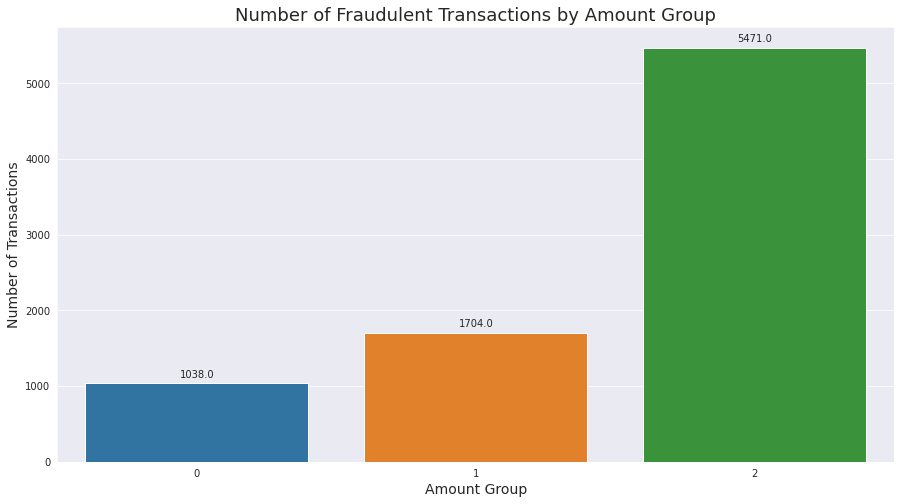

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'amount_group', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Amount Group', 'Amount Group', 'Number of Transactions')



#### H5 - Transactions before the 10th day of the month are more likely to be fraud.
**FALSE**: The number of transactions after 10th is greater than before. Also, the number of frauds per day is well balanced. 


In [ ]:
aux = df4[['day', 'is_fraud']].groupby('day')['is_fraud'].sum().reset_index()

In [ ]:
print('Number of fraudulent transactions before 10th:', aux[aux['day'] <= 10]['is_fraud'].sum())
print('Number of fraudulent transactions after 10th:', aux[aux['day'] > 10]['is_fraud'].sum())

Number of fraudulent transactions before 10th: 2987
Number of fraudulent transactions after 10th: 5226


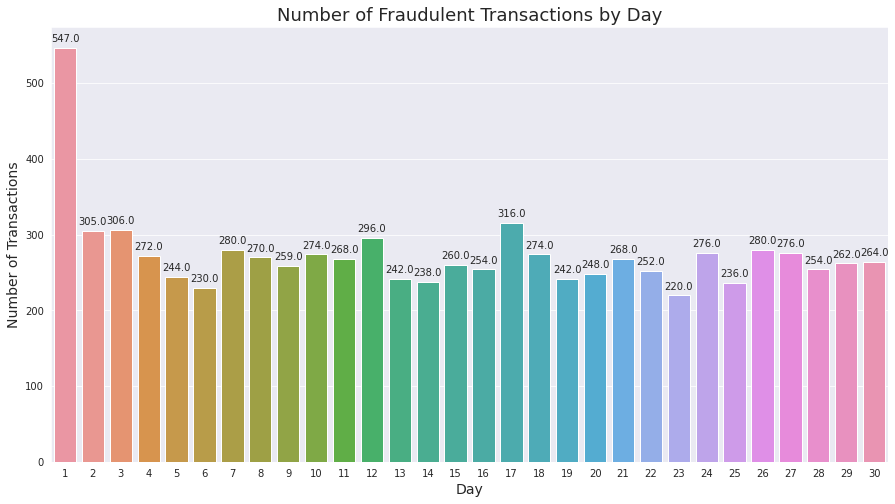

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'day', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Day', 'Day', 'Number of Transactions')

#### H6 - The first week of the month are more likely to be fraud.
**TRUE**: Despite the small difference, the first week is when more fraud happens.


In [ ]:
aux = df4[['week', 'is_fraud']].groupby('week')['is_fraud'].sum().reset_index()

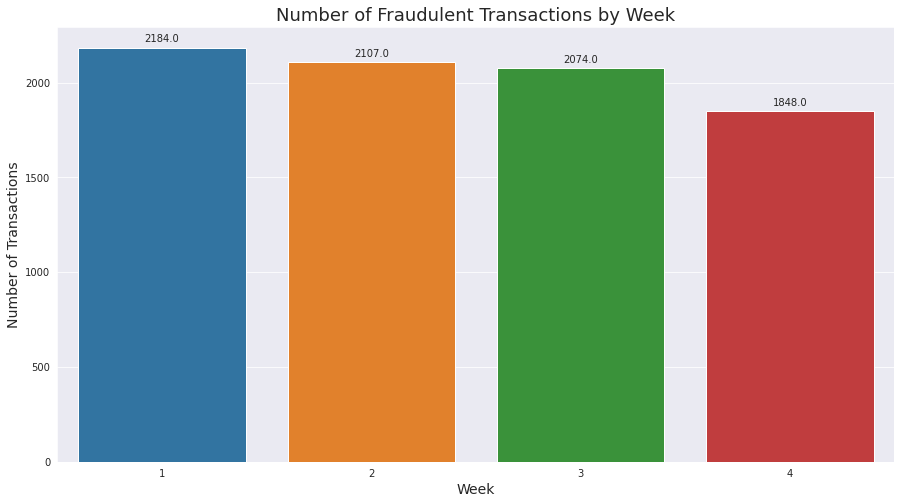

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'week', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Week', 'Week', 'Number of Transactions')

#### H7- Transactions during the work day are more likely to be fraud.
**FALSE**: Fraudulent transactions are more likely to happen during the days of work.


In [ ]:
aux = df4[['day_of_week', 'is_fraud']].groupby('day_of_week')['is_fraud'].sum().reset_index()

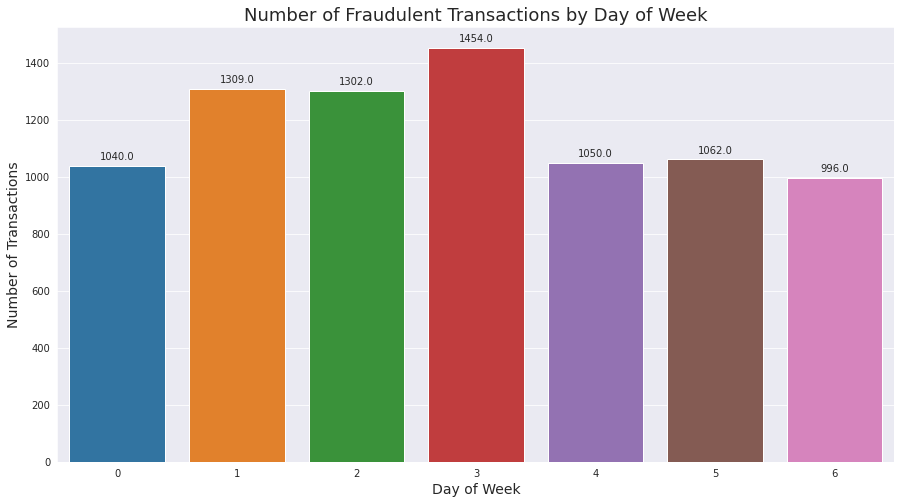

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'day_of_week', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Day of Week', 'Day of Week', 'Number of Transactions')

#### H8 - Transactions after 18h are more likely to be fraud.
**FALSE**: The number of fraudulent transactions during the day and the night is almost the same.


In [ ]:
aux = df4[['hour', 'is_fraud']].groupby('hour')['is_fraud'].sum().reset_index()

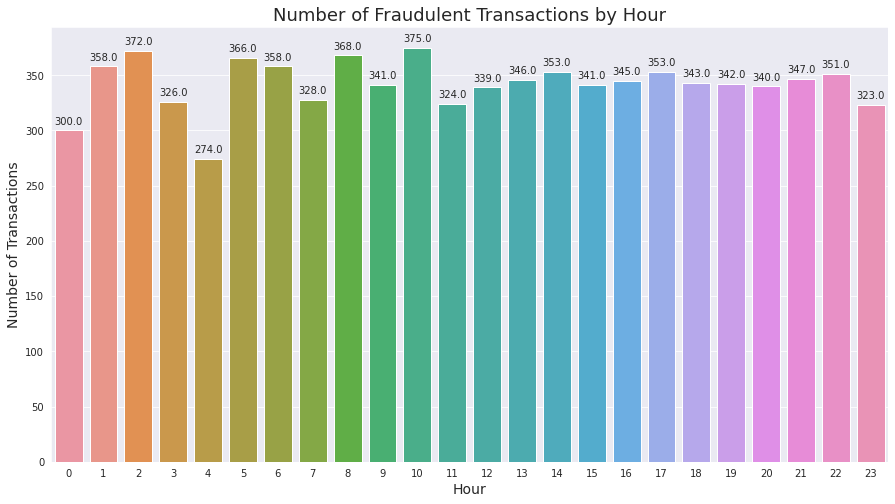

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'hour', y = 'is_fraud', data = aux)
label_graph(ax, '.1f')
set_plots_features(ax, 'Number of Fraudulent Transactions by Hour', 'Hour', 'Number of Transactions')

#### H9 - When the origin new balance is equal zero and the old balance is greater than zero, it is more likely to be fraud;
**TRUE**: Almost always when a fraudulent transaction happen, the newbalance_orig is zero (98%). The percentage of transactions that have newbalance_orig equal zero when is a regular transaction is 35.6%, quite different than the fraudulent ones. 


In [ ]:
aux = df4[df4['oldbalance_orig'] > 0]
aux2 = aux[aux['is_fraud'] == 1]
aux3 = aux2[['is_fraud', 'newbalance_orig']]['newbalance_orig'].value_counts(normalize = True)*100

In [ ]:
aux4 = aux[aux['is_fraud'] == 0]
aux5 = aux4[['is_fraud', 'newbalance_orig']]['newbalance_orig'].value_counts(normalize = True)*100

In [ ]:
aux6 = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux3.head()[0], aux5.head()[0]]})

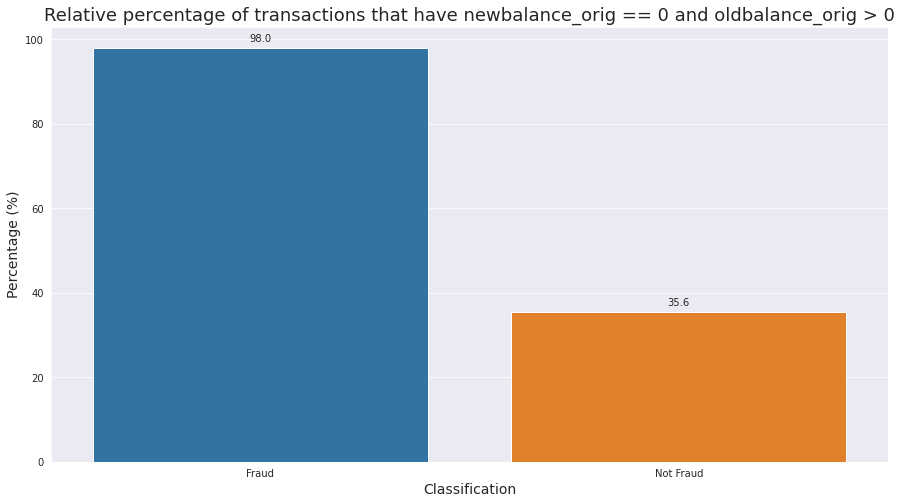

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_orig == 0 and oldbalance_orig > 0', 'Classification', 'Percentage (%)')

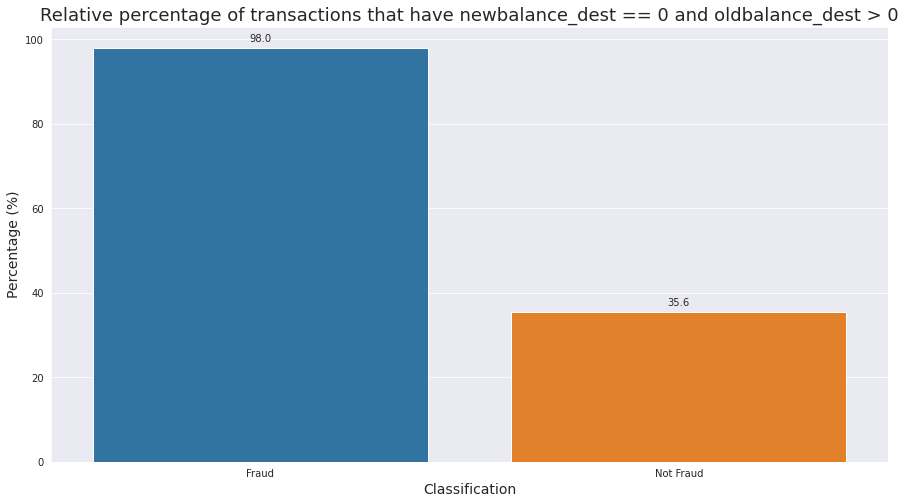

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_dest == 0 and oldbalance_dest > 0', 'Classification', 'Percentage (%)')

#### H10 - When the destination new balance is equal zero and the old balance is greater than zero, it is more likely to be fraud;

**FALSE**: The same pattern of origin account is not followed in the destination account, the relative percentage is very small in both classifications.

In [ ]:
aux = df4[df4['oldbalance_dest'] > 0]
aux2 = aux[aux['is_fraud'] == 1]
aux3 = aux2[['is_fraud', 'newbalance_dest']]['newbalance_dest'].value_counts(normalize = True)*100

In [ ]:
aux4 = aux[aux['is_fraud'] == 0]
aux5 = aux4[['is_fraud', 'newbalance_dest']]['newbalance_dest'].value_counts(normalize = True)*100

In [ ]:
aux6 = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux3.head()[0], aux5.head()[0]]})

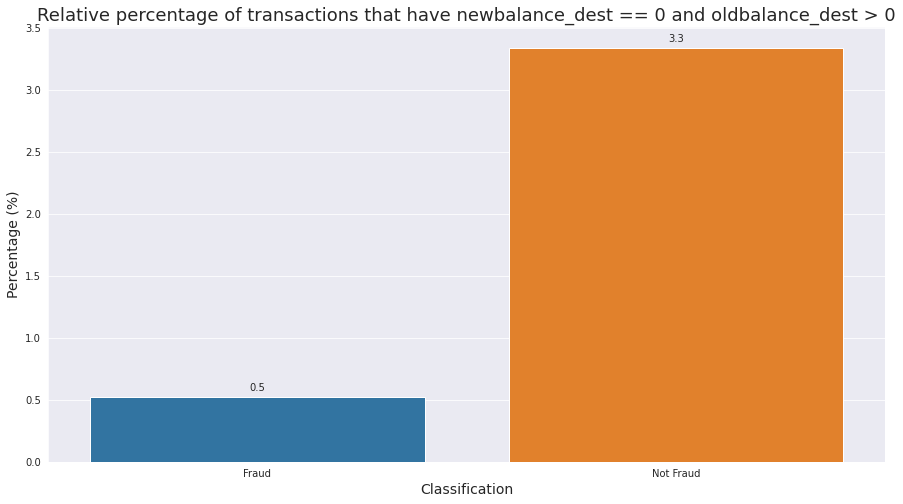

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux6)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions that have newbalance_dest == 0 and oldbalance_dest > 0', 'Classification', 'Percentage (%)')

#### H11 - When the error before and after a transaction in the origin side is different than zero, a fraud occurs.
**FALSE**: Most fraudulent transactions have the error equal to zero.

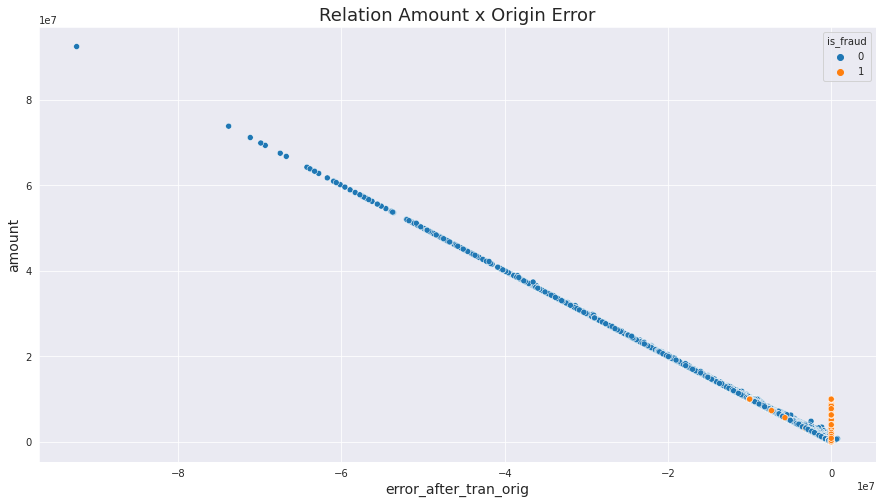

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_orig', y = 'amount', hue = 'is_fraud', data = df4)
set_plots_features(ax, 'Relation Amount x Origin Error', 'error_after_tran_orig', 'amount')

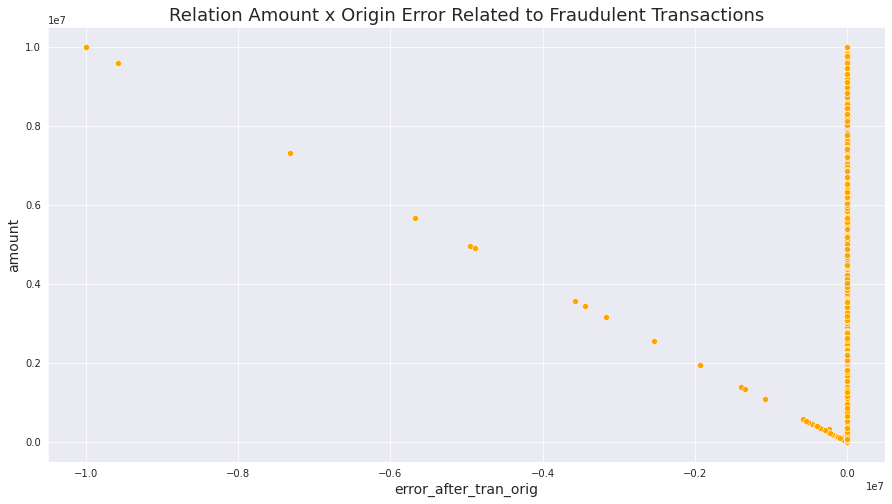

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_orig', y = 'amount', data = df4[df4['is_fraud'] == 1], color = 'orange')
set_plots_features(ax, 'Relation Amount x Origin Error Related to Fraudulent Transactions', 'error_after_tran_orig', 'amount')

In [ ]:
aux = df4[['is_fraud', 'error_after_tran_orig', 'amount']].groupby(['is_fraud', 'error_after_tran_orig'])['amount'].count().reset_index()

In [ ]:
aux_df_fraud = df4[df4['is_fraud'] == 1]
aux_df_nofraud = df4[df4['is_fraud'] == 0]

In [ ]:
aux_fraud = aux[aux['is_fraud'] == 1]
aux_fraud['rel_perc'] = aux_fraud['amount'] / len(aux_df_fraud)
aux_nofraud = aux[aux['is_fraud'] == 0]
aux_nofraud['rel_perc'] = aux_nofraud['amount'] / len(aux_df_nofraud)

aux_fraud = aux_fraud.sort_values('amount', ascending = False).head()*100
aux_nofraud = aux_nofraud.sort_values('amount', ascending = False).head()*100

aux_comp = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux_fraud['rel_perc'].iloc[0], aux_nofraud['rel_perc'].iloc[0]]})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


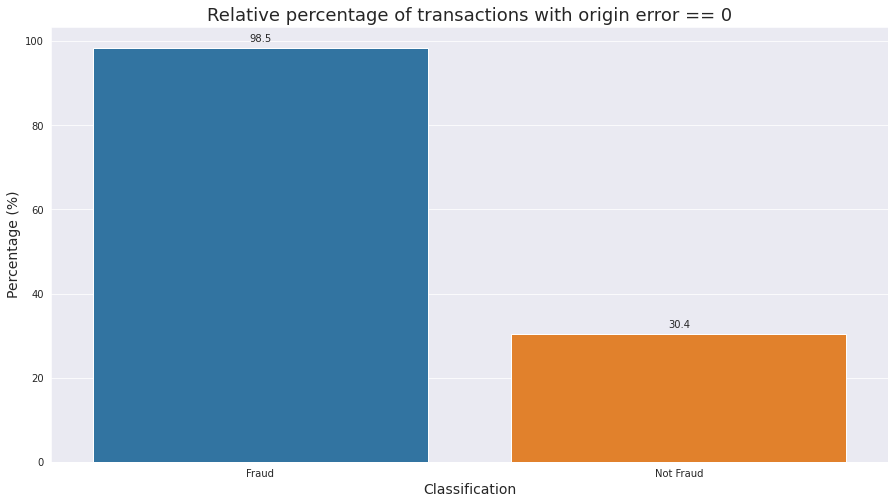

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux_comp)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions with origin error == 0', 'Classification', 'Percentage (%)')

- Most fraudulent transactions have an error in the origin account equal zero, while the regular ones shows a 45º slope (amount = difference)
- A negative value of error means that the transaction amount is not properly taken into account in the origin balance.
- The error in the origin side does not mean a fraudulent transaction, but I think this might be an insight to take into account and fix it quickly.
- Related to fraudulent transactions, 98.5% have the error equal to zero, while the regular transactions have 30.4%.

#### H12 - When the error before and after a transaction in the  destination side is different than zero, a fraud occurs.
**TRUE**: There is a strong pattern that shows fraudulent transactions with error different than zero.

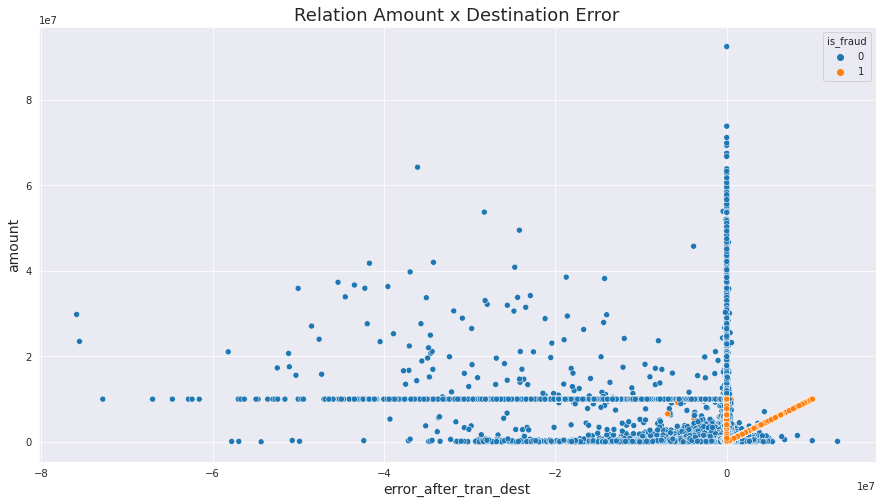

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_dest', y = 'amount', hue = 'is_fraud', data = df4)
set_plots_features(ax, 'Relation Amount x Destination Error', 'error_after_tran_dest', 'amount')

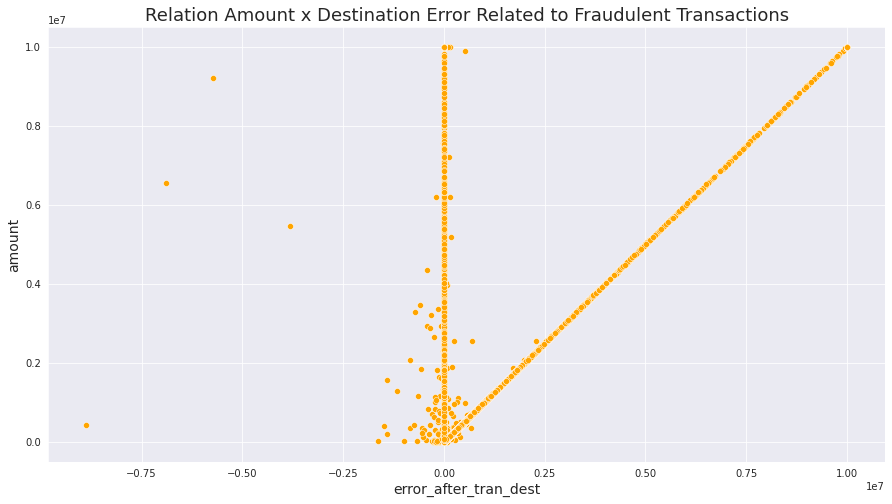

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.scatterplot(x = 'error_after_tran_dest', y = 'amount', data = df4[df4['is_fraud'] == 1], color = 'orange')
set_plots_features(ax, 'Relation Amount x Destination Error Related to Fraudulent Transactions', 'error_after_tran_dest', 'amount')

In [ ]:
aux = df4[['is_fraud', 'error_after_tran_dest', 'amount']].groupby(['is_fraud', 'error_after_tran_dest'])['amount'].count().reset_index()

In [ ]:
aux_fraud = aux[aux['is_fraud'] == 1]
aux_fraud['rel_perc'] = aux_fraud['amount'] / len(aux_df_fraud)
aux_nofraud = aux[aux['is_fraud'] == 0]
aux_nofraud['rel_perc'] = aux_nofraud['amount'] / len(aux_df_nofraud)

aux_fraud = aux_fraud.sort_values('amount', ascending = False).head()*100
aux_nofraud = aux_nofraud.sort_values('amount', ascending = False).head()*100

aux_comp = pd.DataFrame({'relative_percentage': ['Fraud', 'Not Fraud'],
             'values': [aux_fraud['rel_perc'].iloc[0], aux_nofraud['rel_perc'].iloc[0]]})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


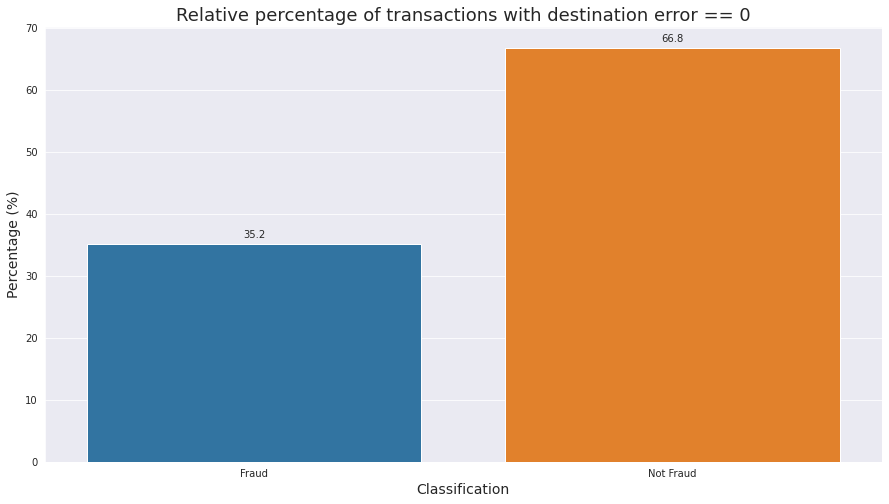

In [ ]:
plt.figure(1, figsize = (15,8))
ax = sns.barplot(x = 'relative_percentage', y = 'values', data = aux_comp)
label_graph(ax, '.1f')
set_plots_features(ax, 'Relative percentage of transactions with destination error == 0', 'Classification', 'Percentage (%)')

- Fraudulent transactions have both patterns, when the error is equal 0 and equal to the amount of money.
- The scatterplot of fraudulent transactions shows when the error in destination account before and after a transaction is equal to the amount of money, a fraud occurs more likely (45º slope);
- Error = Amount means that the balance in destination account does not change after the transaction.
- Related to fraudulent transactions, only 35.2% have the error equal to zero, while the regular transactions have 66.8%.

### 4.3 Multivariate Analysis

In [ ]:
# Separte the numerical and categorical attributes
num_attributes = df4.select_dtypes(include = ['int64', 'int32', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'int32', 'float64', 'datetime64[ns]'])

#### 4.3.1 Numerical Attributes

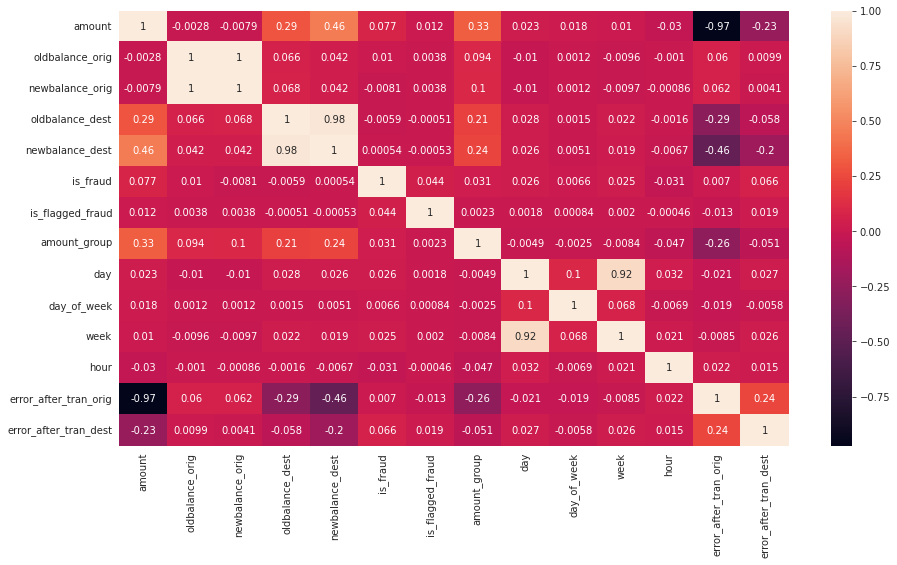

In [ ]:
# Calculate the correlation matrix using the pearson method
corr_matrix = num_attributes.corr(method='pearson')

# Plot the heatmap
plt.figure(1, figsize=(15,8))
sns.heatmap(corr_matrix, annot = True)

- newbalance_orig x oldbalance_orig (1.0 - Indicates colinearity)
- oldbalance_dest x amount (0.29 - medium correlation)
- newbalance_dest x amount (0.46 - medium correlation)
- amount x amount_group (0.33 - medium correlation)
- error_after_tran_orig x amount (-0.97 - strong negative correlation)
- error_after_tran_dest x amount (-023 - medium correlation)
- newbalance_dest x oldbalance_dest (0.98 - strong positive correlation)
- amount_group x newbalance_dest (0.24 - medium correlation)
- error_after_tran_orig x newbalance_dest (-0.46 - medium correlation)
- error_after_tran_orig x amount_group (-0.26 - medium correlation)
- day x week (0.92 - strong positive correlation)
- error_after_tran_orig x error_after_tran_dest (0.24 - medium correlation)

**Observation**:
- Some variables are very strong correlated and that can indicate multicolinearity between the independent features;


#### 4.3.2 Categorical Attributes

The categorical features does not have information with exception of type.

## 5.0 Data Preparation

In [60]:
df5 = df3.copy()

### 5.1 Split train and test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(df5.drop('is_fraud', axis = 1), df5['is_fraud'], test_size = 0.33, random_state = 42)

### 5.3 Rescaling

In [62]:
mms = MinMaxScaler()
rs = RobustScaler()

In [63]:
# MinMax Scaler - Columns that dont follow a normal dist and dont have outliers
# Robust Scaler - Columns that dont follow a normal dist but have outliers
# Standard Scaler - Columns that follow a normal dist

# week mms
X_train['week'] = mms.fit_transform(X_train[['week']])
X_test['week'] = mms.transform(X_test[['week']])
pickle.dump(mms, open('../parameters/scaler_week.pkl', 'wb'))

# Amount
X_train['amount'] = rs.fit_transform(X_train[['amount']])
X_test['amount'] = rs.transform(X_test[['amount']])
pickle.dump(rs, open('../parameters/scaler_amount.pkl', 'wb'))

# oldbalance_orig
X_train['oldbalance_orig'] = rs.fit_transform(X_train[['oldbalance_orig']])
X_test['oldbalance_orig'] = rs.transform(X_test[['oldbalance_orig']])
pickle.dump(rs, open('../parameters/scaler_oldbalance_orig.pkl', 'wb'))

# newbalance_orig
X_train['newbalance_orig'] = rs.fit_transform(X_train[['newbalance_orig']])
X_test['newbalance_orig'] = rs.transform(X_test[['newbalance_orig']])
pickle.dump(rs, open('../parameters/scaler_newbalance_orig.pkl', 'wb'))

# oldbalance_dest
X_train['oldbalance_dest'] = rs.fit_transform(X_train[['oldbalance_dest']])
X_test['oldbalance_dest'] = rs.transform(X_test[['oldbalance_dest']])
pickle.dump(rs, open('../parameters/scaler_oldbalance_dest.pkl', 'wb'))

# newbalance_dest
X_train['newbalance_dest'] = rs.fit_transform(X_train[['newbalance_dest']])
X_test['newbalance_dest'] = rs.transform(X_test[['newbalance_dest']])
pickle.dump(rs, open('../parameters/scaler_newbalance_dest.pkl', 'wb'))

# day
X_train['day'] = rs.fit_transform(X_train[['day']])
X_test['day'] = rs.transform(X_test[['day']])
pickle.dump(rs, open('../parameters/scaler_day.pkl', 'wb'))

# error_after_tran_orig
X_train['error_after_tran_orig'] = rs.fit_transform(X_train[['error_after_tran_orig']])
X_test['error_after_tran_orig'] = rs.transform(X_test[['error_after_tran_orig']])
pickle.dump(rs, open('../parameters/scaler_error_after_tran_orig.pkl', 'wb'))

# error_after_tran_dest
X_train['error_after_tran_dest'] = rs.fit_transform(X_train[['error_after_tran_dest']])
X_test['error_after_tran_dest'] = rs.transform(X_test[['error_after_tran_dest']])
pickle.dump(rs, open('../parameters/scaler_error_after_tran_dest.pkl', 'wb'))



### 5.3 Transformations

In [64]:
# transforming the 'day_of_week' column values into sine and cosine values and creating the new features
X_train['day_of_week_sin'] = X_train['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_train['day_of_week_cos'] = X_train['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))
X_test['day_of_week_sin'] = X_test['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_test['day_of_week_cos'] = X_test['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

# transforming the 'hour' column values into sine and cosine values and creating the new features
X_train['hour_sin'] = X_train['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_train['hour_cos'] = X_train['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))
X_test['hour_sin'] = X_test['hour'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
X_test['hour_cos'] = X_test['hour'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

### 5.4 Categorical Encoding

In [65]:
le = LabelEncoder()

In [66]:
# type
X_train['type'] = le.fit_transform(X_train[['type']])
X_test['type'] = le.transform(X_test[['type']])
pickle.dump(le, open('../parameters/encoding_type.pkl', 'wb'))

# client_origin
X_train['client_origin'] = le.fit_transform(X_train[['client_origin']])
X_test['client_origin'] = le.transform(X_test[['client_origin']])
pickle.dump(le, open('../parameters/encoding_client_origin.pkl', 'wb'))

# client_destination
X_train['client_destination'] = le.fit_transform(X_train[['client_destination']])
X_test['client_destination'] = le.transform(X_test[['client_destination']])
pickle.dump(le, open('../parameters/encoding_client_destination.pkl', 'wb'))

C:\Users\joaop\.conda\envs\blocker-fraud\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


### 5.5 Drop unsed columns

In [67]:
# Dropping the columns not used and the ones used before  transformations
X_train.drop(['date', 'day_of_week', 'hour'], axis = 1, inplace = True)
X_test.drop(['date', 'day_of_week', 'hour'], axis = 1, inplace = True)

## 6.0 Feature Selection

The process of feature selection is very important when a project is done. This can allow the models to become more simple and reduce over-fitting in the training dataset. Then, in this project I will be using the method RFE.

RFE - Recursive Feature Elimination - is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. This is in contrast to filter-based feature selections that score each feature and select those features with the largest (or smallest) score.

Technically, RFE is a wrapper-style feature selection algorithm that also uses filter-based feature selection internally.

RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains.

In [ ]:
X_train.sample()

,type,amount,oldbalance_orig,newbalance_orig,oldbalance_dest,newbalance_dest,is_flagged_fraud,amount_group,day,week,error_after_tran_orig,error_after_tran_dest,client_origin,client_destination,day_of_week_sin,day_of_week_cos,hour_sin,hour_cos
1867696,1,-0.126538,-0.132085,0.0,-0.048894,0.071309,0,1,-0.428571,0.0,-0.387022,-157091.17,0,0,0.0,1.0,-0.781831,0.62349


In [ ]:
# Recursive Feature Elimination
'''

# Random forest for choose the best features
rfr = RandomForestClassifier(n_estimators= 100, n_jobs= -1, random_state= 42)

# instatiating the RFE model as 'rfe' and that we want RFE to select the 12 best features
rfe = RFE(rfr, n_features_to_select= 10, step= 1)

# training the RFE model
rfe = rfe.fit(X_train, y_train)

# Rank the best features
selected_features = rfe.support_.tolist()

# Name of each feature 
features_columns = X_train.columns

rfe_selected_features = []

# inserting the selected features into the 'rfe_selected_features'
for binary, feature in zip(selected_features, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)


'''

"\n\n# Random forest for choose the best features\nrfr = RandomForestClassifier(n_estimators= 100, n_jobs= -1, random_state= 42)\n\n# instatiating the RFE model as 'rfe' and that we want RFE to select the 12 best features\nrfe = RFE(rfr, n_features_to_select= 10, step= 1)\n\n# training the RFE model\nrfe = rfe.fit(X_train, y_train)\n\n# Rank the best features\nselected_features = rfe.support_.tolist()\n\n# Name of each feature \nfeatures_columns = X_train.columns\n\nrfe_selected_features = []\n\n# inserting the selected features into the 'rfe_selected_features'\nfor binary, feature in zip(selected_features, features_columns):\n    if binary == True:\n        rfe_selected_features.append(feature)\n\n\n"

In [68]:
rfe_selected_features = ['type', 'amount', 'oldbalance_orig', 'newbalance_orig', 'oldbalance_dest', 'newbalance_dest', 'day', 'week', 'error_after_tran_orig', 'error_after_tran_dest']

## 7.0 Machine Learning Models

- Logistic Regression
- Naive Bayes
- Extra Trees
- Random Forest Classifier
- CatBoost Classifier
- KNN
- LGBM Classifier

### 7.1 Baseline Model - Flagged Frauds

In [90]:
baseline_preds = X_test['is_flagged_fraud']

baseline_metrics = get_metrics('Baseline Model', y_test, baseline_preds)
baseline_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Baseline Model,0.998734,1.0,0.002626,0.005238


### 7.2 Logistic Regression 

In [ ]:
# LogisticRegression Model
lr_model = LogisticRegression()

# Fit train dataset
lr_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
lr_preds = lr_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
lr_metrics = get_metrics('Logistic Regression', y_test, lr_preds)
lr_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Logistic Regression,0.998912,0.694586,0.255064,0.373114


Text(0.5, 1.0, 'Confusion Matrix of Logistic Regression')

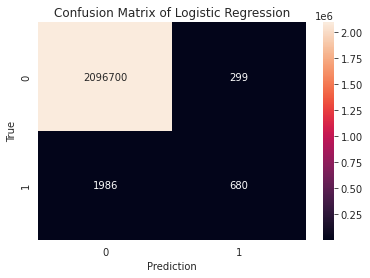

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, lr_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of Logistic Regression')

### 7.2.1 Cross-Validation for Logistic Regression

In [ ]:
lr_cv = cross_validation('Logistic Regression - CV', lr_model, X_train, y_train, 5)
lr_cv

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,Logistic Regression - CV,0.998 +/- 0.00123,0.609 +/- 0.30492,0.299 +/- 0.18149,0.393 +/- 0.21881


### 7.3 Naïve Bayes

In [ ]:
# Gaussian Naive Bayes Model
nb_model = GaussianNB()

# Fit train dataset
nb_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
nb_preds = nb_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
nb_metrics = get_metrics('Gaussian NB', y_test, nb_preds)
nb_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Gaussian NB,0.997128,0.077387,0.115529,0.092687


Text(0.5, 1.0, 'Confusion Matrix of GaussianNB')

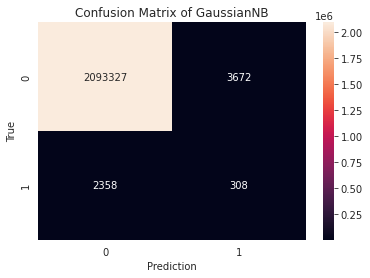

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, nb_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of GaussianNB')

#### 7.3.1 Cross-validation for Gaussian NB

In [ ]:
nb_cv = cross_validation('Gaussian NB - CV', nb_model, X_train, y_train, 5)
nb_cv

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,Gaussian NB - CV,0.997 +/- 3e-05,0.085 +/- 0.00699,0.122 +/- 0.00987,0.101 +/- 0.00818


### 7.4 Random Forest Classifier

In [ ]:
# RandomForest Classifier Model
rf_model = RandomForestClassifier(n_estimators=100, random_state = 42)

# Fit train dataset
rf_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
rf_preds = rf_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
rf_metrics = get_metrics('Random Forest', y_test, rf_preds)
rf_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.999993,0.998871,0.995874,0.99737


Text(0.5, 1.0, 'Confusion Matrix of Random Forest')

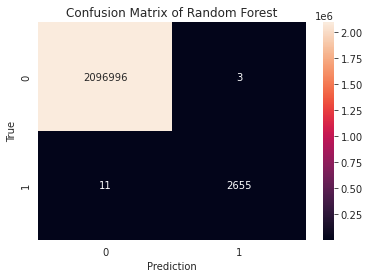

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, rf_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of Random Forest')

#### 7.4.1 Cross-validation for Random Forest

In [ ]:
rf_cv = cross_validation('Random Forest - CV', rf_model, X_train, y_train, 5)
rf_cv

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,Random Forest - CV,1.0 +/- 0.0,1.0 +/- 0.00036,0.996 +/- 0.00067,0.998 +/- 0.00046


### 7.5 Extra Trees

In [ ]:
# ExtraTree Classifier Model
et_model = ExtraTreesClassifier(n_estimators=100, random_state = 42)

# Fit train dataset
et_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
et_preds = et_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
et_metrics = get_metrics('Extra Trees', y_test, et_preds)
et_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,Extra Trees,0.999749,0.977252,0.82183,0.892828


Text(0.5, 1.0, 'Confusion Matrix of Extra Trees')

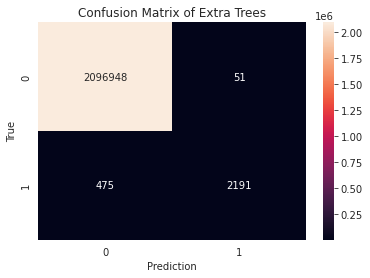

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, et_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of Extra Trees')

#### 7.5.1 Cross-validation for Extra Trees 

In [ ]:
et_cv = cross_validation('Extra Trees - CV', et_model, X_train, y_train, 5)
et_cv

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,Extra Trees - CV,1.0 +/- 1e-05,0.977 +/- 0.00324,0.748 +/- 0.00985,0.847 +/- 0.00542


### 7.6 CatBoost 

In [ ]:
# CatBoost Classifier Model
cb_model = CatBoostClassifier(iterations=30, learning_rate=0.1, depth=10)

# Fit train dataset
cb_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
cb_preds = cb_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
cb_metrics = get_metrics('Cat Boost', y_test, cb_preds)
cb_metrics

0:	learn: 0.5963658	total: 1.41s	remaining: 12.7s
1:	learn: 0.5196754	total: 2.65s	remaining: 10.6s
2:	learn: 0.4544152	total: 3.94s	remaining: 9.19s
3:	learn: 0.4028982	total: 5.13s	remaining: 7.7s
4:	learn: 0.3555970	total: 6.11s	remaining: 6.11s
5:	learn: 0.3135032	total: 7.38s	remaining: 4.92s
6:	learn: 0.2806490	total: 8.63s	remaining: 3.7s
7:	learn: 0.2497818	total: 9.73s	remaining: 2.43s
8:	learn: 0.2213756	total: 11s	remaining: 1.22s
9:	learn: 0.1981200	total: 12.3s	remaining: 0us


,Model Name,Accuracy,Precision,Recall,F1-Score
0,Cat Boost,0.999512,0.999391,0.615904,0.762126


Text(0.5, 1.0, 'Confusion Matrix of Cat Boost')

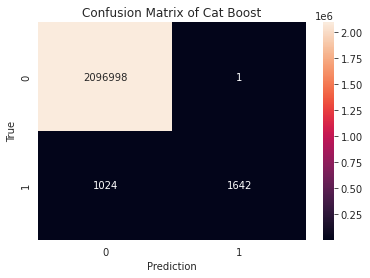

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, cb_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of Cat Boost')

#### 7.6.1 Cross-validation for CatBoost

In [ ]:
cb_cv = cross_validation('CatBoost - CV', cb_model, X_train, y_train, 5)
cb_cv

0:	learn: 0.5970861	total: 1.1s	remaining: 9.93s
1:	learn: 0.5197940	total: 2.5s	remaining: 10s
2:	learn: 0.4549400	total: 3.79s	remaining: 8.84s
3:	learn: 0.4022670	total: 4.67s	remaining: 7s
4:	learn: 0.3549933	total: 5.22s	remaining: 5.22s
5:	learn: 0.3137548	total: 6.49s	remaining: 4.33s
6:	learn: 0.2804956	total: 7.8s	remaining: 3.34s
7:	learn: 0.2497285	total: 9.1s	remaining: 2.27s
8:	learn: 0.2220593	total: 10.4s	remaining: 1.16s
9:	learn: 0.1988153	total: 11.8s	remaining: 0us
0:	learn: 0.5969841	total: 1.27s	remaining: 11.5s
1:	learn: 0.5196104	total: 2.71s	remaining: 10.8s
2:	learn: 0.4547399	total: 4.08s	remaining: 9.51s
3:	learn: 0.4020524	total: 5.35s	remaining: 8.02s
4:	learn: 0.3547115	total: 6.77s	remaining: 6.77s
5:	learn: 0.3138540	total: 8.16s	remaining: 5.44s
6:	learn: 0.2806246	total: 9.51s	remaining: 4.07s
7:	learn: 0.2499939	total: 10.8s	remaining: 2.7s
8:	learn: 0.2222101	total: 12.1s	remaining: 1.34s
9:	learn: 0.1988952	total: 13.4s	remaining: 0us
0:	learn: 0.59

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,CatBoost - CV,0.999 +/- 3e-05,1.0 +/- 0.00066,0.55 +/- 0.02258,0.709 +/- 0.01879


### 7.7 LGBM Classifier

In [ ]:
# LGBM Model
lgbm_model = LGBMClassifier(random_state= 42)

# Fit train dataset
lgbm_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
lgbm_preds = lgbm_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
lgbm_metrics = get_metrics('LGBM', y_test, lgbm_preds)
lgbm_metrics

,Model Name,Accuracy,Precision,Recall,F1-Score
0,LGBM,0.998226,0.150033,0.085146,0.108638


Text(0.5, 1.0, 'Confusion Matrix of LGBM')

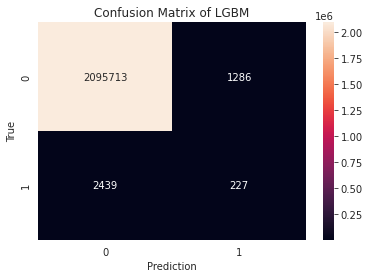

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, lgbm_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of LGBM')

#### 7.7.1 Cross-validation for LGBM

In [ ]:
lgbm_cv = cross_validation('LGBM - CV', lgbm_model, X_train, y_train, 5)
lgbm_cv

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,LGBM - CV,0.997 +/- 0.00156,0.167 +/- 0.18923,0.193 +/- 0.149,0.166 +/- 0.16421


### 7.8 XGBoost

In [ ]:
# XGBoost Model
xgb_model = XGBClassifier(n_estimators = 100, random_state= 42)

# Fit train dataset
xgb_model.fit(X_train[rfe_selected_features], y_train)

# Prediction with the test dataset
xgb_preds = xgb_model.predict(X_test[rfe_selected_features])

# Get the metrics for the model
xgb_metrics = get_metrics('XGBoost', y_test, xgb_preds)
xgb_metrics

[20:07:37] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


,Model Name,Accuracy,Precision,Recall,F1-Score
0,XGBoost,0.99999,0.996622,0.995874,0.996248


Text(0.5, 1.0, 'Confusion Matrix of XGBoost')

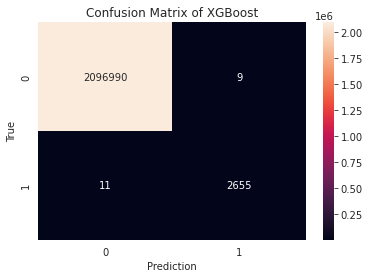

In [ ]:
# Plot of the confusion matrix to help the decision
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot = True, fmt = 'd')
plt.ylabel('True')
plt.xlabel('Prediction')
plt.title('Confusion Matrix of XGBoost')

#### 7.8.1 Cross-validation for XGBoost

In [ ]:
xgb_cv = cross_validation('XGBoost - CV', xgb_model, X_train, y_train, 5)
xgb_cv

,Model,Accuracy CV,Precision CV,Recall CV,F1-Score CV
0,XGBoost - CV,1.0 +/- 0.0,1.0 +/- 0.00036,0.996 +/- 0.00072,0.998 +/- 0.00034


Choosing the best model, it is necessary to evaluate the business information on the model. Since we are classifying a fraud and the value is specific for each classification, let me write below some infos:

- The company will receive 25% of value for each transaction detected as a real Fraud. (True Positive)
- The company receives 5% of value for each transaction detected as a Fraud, but the transaction was real legitimate. (False Positive)
- The company will charge back 100% of  the value for each transaction that was detected as legitimate, but the transaction was a real fraud. (False Negative)


Then, since we need to maximize the True positive (will generate profit), we need to pay attention to Recall (True Positive / All positives). Also, we don't want the case of charge back too, so we need to pay attention at the False Negative number (low value will maximize profit).

Based on this assumptions, the best 2 models are Random Forest and XGBoost. Both have the same performance. For this particular case, I will choose Random Forest Classifier to advance to the step of hyper-paramters tunning.

## 8.0 Hyper-parameters Tunning 

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
'''
cv = StratifiedKFold(n_splits=5, shuffle = True, random_state=42)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                           {
                              'n_estimators':[100, 300, 500, 1000],
                              'max_depth': [2, 4, 8, 16, 32],
                              'min_samples_leaf': [2, 8, 16, 32],
                              'min_samples_split': [2, 4, 8, 16, 32]
                            ' '
                            
                            },cv=cv, n_iter = 10, scoring="recall",verbose=1,n_jobs=-1
                           )
random_search.fit(X_train,y_train)
'''

In [ ]:
#print(random_search.best_params_)
#print(random_search.best_score_)

# Best params generated using 30% of the dataset.
#n_estimatos = 300, min_samples_split = 4, min_samples_leaf = 2, max_depth = 32

In [ ]:
final_model_tunned = RandomForestClassifier(n_estimators= 300, min_samples_split= 4, min_samples_leaf= 2, max_depth= 32)
final_model_tunned.fit(X_train[rfe_selected_features], y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=32, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pickle.dump(final_model_tunned, open('..model/rf_final_tunned.pkl', 'wb'))

## 9.0 Business Performance

In [47]:
final_model_tunned = pickle.load(open('../model/rf_final_tunned.pkl', 'rb'))
preds_model = final_model_tunned.predict(X_test[rfe_selected_features])

In [48]:
# I use the index of X_test in order to find the features information before transformations and rescaling
test_set = df1.loc[X_test.index]

# Add the prediction to the dataframe
test_set['prediction_model'] = preds_model

test_set.sample()

,step,type,amount,name_orig,oldbalance_orig,newbalance_orig,name_dest,oldbalance_dest,newbalance_dest,is_fraud,is_flagged_fraud,prediction_model
5187371,361,PAYMENT,15672.02,C1500789564,0.0,0.0,M165745312,0.0,0.0,0,0,0


In [97]:
# Baseline Results
true_fraud_detect_amount = test_set[(test_set['is_fraud'] == 1) & (test_set['is_flagged_fraud'] == 1)]['amount'].sum()
number_true_fraud = len(test_set[(test_set['is_fraud'] == 1) & (test_set['is_flagged_fraud'] == 1)])

false_fraud_detect_amount = test_set[(test_set['is_fraud'] == 0) & (test_set['is_flagged_fraud'] == 1)]['amount'].sum()
number_false_fraud = len(test_set[(test_set['is_fraud'] == 0) & (test_set['is_flagged_fraud'] == 1)])

lost_amount = test_set[(test_set['is_fraud'] == 1) & (test_set['is_flagged_fraud'] == 0)]['amount'].sum()
number_lost = len(test_set[(test_set['is_fraud'] == 1) & (test_set['is_flagged_fraud'] == 0)])


print('Baseline Results:')
print('The dataset provided has {:.2f}% of fraudulent data.'.format(100*len(test_set[test_set['is_fraud'] == 1])/len(test_set)))
print('The baseline model achieved 0.26% of Precision to detect a fraudulent transaction, which means {} frauds detected correcly in one month.'.format(number_true_fraud))

print('\n')

print('Client Results:')
print('The client could lost ${:,.2f} due to the fraudulent transactions.'.format(test_set[test_set['is_fraud'] == 1]['amount'].sum()))
print('Using the baseline model, the client actually lost ${:,.2f}.'.format(lost_amount))
print('Finally, they saved ${:,.2f}.'.format(test_set[test_set['is_fraud'] == 1]['amount'].sum() - lost_amount))


Baseline Results:
The dataset provided has 0.13% of fraudulent data.
The baseline model achieved 0.26% of Precision to detect a fraudulent transaction, which means 7 frauds detected correcly in one month.


Client Results:
The client could lost $3,805,581,494.00 due to the fraudulent transactions.
Using the baseline model, the client actually lost $3,768,273,444.38.
Finally, they saved $37,308,049.62.


In [85]:
# MODEL RESULTS
# First assumption: The company will receive 25% of value for each transaction detected as a real Fraud. (True Positive)
true_fraud_detect_amount = test_set[(test_set['is_fraud'] == 1) & (test_set['prediction_model'] == 1)]['amount'].sum()
number_true_fraud = len(test_set[(test_set['is_fraud'] == 1) & (test_set['prediction_model'] == 1)])

# Second assumption: The company receives 5% of value for each transaction detected as a Fraud, but the transaction was real legitimate. (False Positive)
false_fraud_detect_amount = test_set[(test_set['is_fraud'] == 0) & (test_set['prediction_model'] == 1)]['amount'].sum()
number_false_fraud = len(test_set[(test_set['is_fraud'] == 0) & (test_set['prediction_model'] == 1)])
# Third assumption: The company will charge back 100% of the value for each transaction that was detected as legitimate, but the transaction was a real fraud. (False Negative)
charge_back_amount = test_set[(test_set['is_fraud'] == 1) & (test_set['prediction_model'] == 0)]['amount'].sum()
number_charge_back = len(test_set[(test_set['is_fraud'] == 1) & (test_set['prediction_model'] == 0)])


total_blocker_profit = 0.25*true_fraud_detect_amount + 0.05*false_fraud_detect_amount - 1*charge_back_amount

print('Model Results:')
print('The dataset provided has {:.2f}% of fraudulent data.'.format(100*len(test_set[test_set['is_fraud'] == 1])/len(test_set)))
print('Our model achieved 99% of Precision to detect a fraudulent transaction, which means {} frauds detected correcly in one month.'.format(number_true_fraud))

print('\n')

print('Blocker Fraud Company Financial Results:')
print('The company receives an estimated revenue of ${:,.2f} from {} transactions detect as a fraud.'.format(0.25*true_fraud_detect_amount, number_true_fraud ))
print('The company receives an estimated revenue of ${:,.2f} from {} transactions classified as possible frauds.'.format(0.05*false_fraud_detect_amount, number_false_fraud))
print('The company has to pay as charge back an estimated amount of ${:,.2f} from {} transactions that the model lost.'.format(1*charge_back_amount, number_charge_back))
print('Estimated profit: ${:,.2f}'.format(total_blocker_profit))

print('\n')
print('Client Benefits:')
print('The client could lost ${:,.2f} due to the fraudulent transactions.'.format(test_set[test_set['is_fraud'] == 1]['amount'].sum()))
print('Using the blocker fraud model, the client actually lost ${:,.2f} (payment to the Blocker Fraud Company).'.format(total_blocker_profit))
print('Finally, they saved ${:,.2f}.'.format(test_set[test_set['is_fraud'] == 1]['amount'].sum() - total_blocker_profit))


Model Results:
The dataset provided has 0.13% of fraudulent data.
Our model achieved 99% of Precision to detect a fraudulent transaction, which means 2655 frauds detected correcly in one month.


Blocker Fraud Company Financial Results:
The company receives an estimated revenue of $950,509,043.18 from 2655 transactions detect as a fraud.
The company receives an estimated revenue of $135.88 from 3 transactions classified as possible frauds.
The company has to pay as charge back an estimated amount of $3,545,321.29 from 11 transactions that the model lost.
Estimated profit: $946,963,857.77


Client Benefits:
The client could lost $3,805,581,494.00 due to the fraudulent transactions.
Using the blocker fraud model, the client actually lost $946,963,857.77 (payment to the Blocker Fraud Company).
Finally, they saved $2,858,617,636.23.


## 10.0 Deploy

### 10.1 API Testing

In [1]:
import requests
import pandas as pd

In [2]:
# Read new data
df_test = pd.read_csv('../data/sample.csv',low_memory=True)

In [3]:
df_test = df_test.sample()

In [4]:
df_test

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
1,1,PAYMENT,1864.28,C1666544295,21249,19384.72,M2044282225,0,0,0


In [5]:
# Convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [10]:
# API CALL
#https://blocker-fraud-api.herokuapp.com/
url = 'https://blocker-fraud-api.herokuapp.com//blocker/predict'
header = {'Content-type': 'application/json'}
data = data


r = requests.post(url, data = data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [7]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
d1

In [ ]:
if d1['predictions'][0] == 1:
    print("Transaction from d1['name_orig'] to d1['name_dest'] is a fraud.".format(d1['name_orig'], d1['name_dest']))
else:
    print("Transaction from {} to {} is legitimate.".format(d1['name_orig'][0], d1['name_dest'][0]))

## Next Steps:

- Using Heroku to display the report for the client;